## AdaGrad with Gradient Differences

Standard AdaGrad accumulates the sum of squares of past gradients, which is used to adjust the learning rate:
$$
\begin{aligned}
& G_t= \| g_t \|_2 \\
& \theta_{t+1}=\theta_t-\frac{\eta}{G_t+\epsilon} \cdot g_t
\end{aligned}
$$

Modified AdaGrad with gradient differences accumulates the sum of squares of differences between successive gradients:
$$
\begin{aligned}
& D_t= \| \Delta g_t \|_2
& \text{where} \; \Delta g_t=g_t-g_{t-1} \\
& \theta_{t+1}=\theta_t-\frac{\eta}{D_t +\epsilon} \cdot g_t
\end{aligned}
$$


In [1]:
import math
import torch
from torch.optim import Optimizer

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import time
import matplotlib.pyplot as plt

In [3]:
class AdaGradWithDiff(Optimizer):
    """
    AdaGrad optimizer with gradient differences for stepsize calculation.
    """
    def __init__(self, params, lr=1e-2, eps=1e-8):
        """
        Initializes the optimizer with hyperparameters.

        Args:
            params (iterable): Iterable of parameters to optimize.
            lr (float, optional): Learning rate. Defaults to 1e-2.
            eps (float, optional): Epsilon for numerical stability. Defaults to 1e-8.
        """
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))

        defaults = dict(lr=lr, eps=eps)
        super(AdaGradWithDiff, self).__init__(params, defaults)

        # State initialization
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0                                   # Steps for optimization
                state['sum_grad_diffs'] = torch.zeros_like(p.data)  # Sum of gradient difference
                state['prev_grad'] = torch.zeros_like(p.data)       # Previous gradient

    def __setstate__(self, state):
        super(AdaGradWithDiff, self).__setstate__(state)

    def step(self, closure=None):
        """
        Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss. Defaults to None.

        Returns:
            Optional[Tensor]: None if closure is None, otherwise
                the closure return value.
        """
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('AdaGradWithDiff does not support sparse gradients, please consider other optimizers.')

                state = self.state[p]

                state['step'] += 1
                sum_grad_diffs, prev_grad = state['sum_grad_diffs'], state['prev_grad']

                grad_diff = abs(prev_grad - grad)

                sum_grad_diffs.addcmul_(grad_diff, grad_diff)
                denom = sum_grad_diffs.sqrt().add_(group['eps'])

                p.data.addcdiv_(-group['lr'], grad, denom)

                # At the end, change previous gradient to current gradient
                state['prev_grad'] = grad.clone()
                state['sum_grad_diffs'] = sum_grad_diffs.clone()

        return loss, denom.sum()

class AdaGrad(Optimizer):
    def __init__(self, params, lr=1e-2, eps=1e-10):
        """
        Initializes the optimizer with hyperparameters.

        Args:
            params (iterable): Iterable of parameters to optimize.
            lr (float, optional): Learning rate. Defaults to 1e-2.
            eps (float, optional): Epsilon for numerical stability. Defaults to 1e-8.
        """
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))

        defaults = dict(lr=lr, eps=eps)
        super(AdaGrad, self).__init__(params, defaults)

        # State initialization
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0                                   # Steps for optimization
                state['sum_grads'] = torch.zeros_like(p.data)  # Sum of gradient difference

    def __setstate__(self, state):
        super(AdaGrad, self).__setstate__(state)

    def step(self, closure=None):
        """
        Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss. Defaults to None.

        Returns:
            Optional[Tensor]: None if closure is None, otherwise
                the closure return value.
        """
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('AdaGrad does not support sparse gradients, please consider other optimizers.')

                state = self.state[p]

                state['step'] += 1
                sum_grads = state['sum_grads']

                sum_grads.addcmul_(grad, grad)
                denom = sum_grads.sqrt().add_(group['eps'])

                p.data.addcdiv_(-group['lr'], grad, denom)

                state['sum_grads'] = sum_grads.clone()

        return loss, denom.sum()

## Adam with Gradient Differences


Standard Adam accumulates the sum of squares of past gradients, which is used to adjust the learning rate:
\begin{align*}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t, \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2, \\
\hat{m_t} &= \frac{m_t}{1 - \beta_1^t}, \\
\hat{v_t} &= \frac{v_t}{1 - \beta_2^t}, \\
\theta_t &= \theta_{t-1} - \alpha \cdot \frac{\hat{m_t}}{\sqrt{\hat{v_t}} + \epsilon},
\end{align*}

Modified Adam with gradient differences accumulates the sum of squares of differences between successive gradients:
$$
\begin{aligned}
& D_t= \| \Delta g_t \|_2
& \text{where} \; \Delta g_t=g_t-g_{t-1} \\
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t, \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) D_t, \\
\hat{m_t} &= \frac{m_t}{1 - \beta_1^t}, \\
\hat{v_t} &= \frac{v_t}{1 - \beta_2^t}, \\
\theta_t &= \theta_{t-1} - \alpha \cdot \frac{\hat{m_t}}{\sqrt{\hat{v_t}} + \epsilon},
\end{aligned}
$$


In [2]:
class AdamWithDiff(Optimizer):
    """
    Adam optimizer with gradient differences for stepsize calculation.
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, correct_bias=True):
        """
        Initializes the optimizer with hyperparameters.

        Args:
            params (iterable): Iterable of parameters to optimize.
            lr (float, optional): Learning rate. Defaults to 1e-3.
            betas (tuple, optional): Coefficients used for computing running averages
                of gradient and its square (default: (0.9, 0.999)).
            eps (float, optional): Epsilon for numerical stability. Defaults to 1e-8.
            amsgrad (bool, optional): Whether to use the AMSGrad variant. Defaults to False.
        """
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, correct_bias=correct_bias)
        super(AdamWithDiff, self).__init__(params, defaults)

        # State initialization
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0                               # Steps for optimization
                state['m'] = torch.zeros_like(p.data)      # Exponential moving average of gradient values
                state['v'] = torch.zeros_like(p.data)   # Exponential moving average of squared gradient values
                state['prev_grad'] = torch.zeros_like(p.data)   # Previous gradient

    def __setstate__(self, state):
        super(AdamWithDiff, self).__setstate__(state)

    def step(self, closure=None):
        """
        Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss. Defaults to None.

        Returns:
            Optional[Tensor]: None if closure is None, otherwise
                the closure return value.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('AdamWithDiff does not support sparse gradients, please consider other optimizers.')
                state = self.state[p]

                state['step'] += 1
                m, v, prev_grad, = state['m'], state['v'], state['prev_grad']
                beta1, beta2 = group['betas']


                # Just adding the square of the weights to the loss function is *not*
                # the correct way of using L2 regularization/weight decay with Adam,
                # since that will interact with the m and v parameters in strange ways.
                #
                # Instead we want to decay the weights in a manner that doesn't interact
                # with the m/v parameters. This is equivalent to adding the square
                # of the weights to the loss with plain (non-momentum) SGD.
                # Add weight decay at the end (fixed version)
                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                grad_diff = abs(grad - prev_grad)

                m.mul_(beta1).add_(1 - beta1, grad)
                v.mul_(beta2).addcmul_(1 - beta2, grad_diff, grad_diff)

                # if group['correct_bias']:
                m_hat = m / (1 - beta1 ** state['step'])
                v_hat = v / (1 - beta2 ** state['step'])
                denom = v_hat.sqrt().add_(group['eps'])

                p.data.addcdiv_(-group['lr'], m_hat, denom)

                state['prev_grad'] = grad.clone()
                state['m'], state['v'] = m.clone(), v.clone()


        return loss, denom.sum()

class Adam(Optimizer):
    """
    Adam optimizer with gradient differences for stepsize calculation.
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, correct_bias=True):
        """
        Initializes the optimizer with hyperparameters.

        Args:
            params (iterable): Iterable of parameters to optimize.
            lr (float, optional): Learning rate. Defaults to 1e-3.
            betas (tuple, optional): Coefficients used for computing running averages
                of gradient and its square (default: (0.9, 0.999)).
            eps (float, optional): Epsilon for numerical stability. Defaults to 1e-8.
            amsgrad (bool, optional): Whether to use the AMSGrad variant. Defaults to False.
        """
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, correct_bias=correct_bias)
        super(Adam, self).__init__(params, defaults)

        # State initialization
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0                               # Steps for optimization
                state['m'] = torch.zeros_like(p.data)      # Exponential moving average of gradient values
                state['v'] = torch.zeros_like(p.data)   # Exponential moving average of squared gradient values

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)

    def step(self, closure=None):
        """
        Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss. Defaults to None.

        Returns:
            Optional[Tensor]: None if closure is None, otherwise
                the closure return value.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('AdamWithDiff does not support sparse gradients, please consider other optimizers.')
                state = self.state[p]

                state['step'] += 1
                m, v = state['m'], state['v']
                beta1, beta2 = group['betas']

                # Just adding the square of the weights to the loss function is *not*
                # the correct way of using L2 regularization/weight decay with Adam,
                # since that will interact with the m and v parameters in strange ways.
                #
                # Instead we want to decay the weights in a manner that doesn't interact
                # with the m/v parameters. This is equivalent to adding the square
                # of the weights to the loss with plain (non-momentum) SGD.
                # Add weight decay at the end (fixed version)
                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # grad_diff = abs(grad - prev_grad)

                m.mul_(beta1).add_(1 - beta1, grad)
                v.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # if group['correct_bias']:
                m_hat = m / (1 - beta1 ** state['step'])
                v_hat = v / (1 - beta2 ** state['step'])
                denom = v_hat.sqrt().add_(group['eps'])

                p.data.addcdiv_(-group['lr'], m_hat, denom)

                state['m'], state['v'] = m.clone(), v.clone()

        return loss, denom.sum()

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [55]:
# Define Logistic Regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

# Function to train the model and track both training and test accuracy
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=100, log_at=25):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        val_loss, val_acc = val_model(model, test_loader, criterion, epoch, log_at)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if epoch % log_at == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    return train_losses, train_accuracies, val_losses, val_accuracies

def val_model(model, test_loader, criterion, epoch_num, log_at):
    # Evaluate on test set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    val_loss = val_loss / len(test_loader)
    val_acc = 100.0 * correct / total

    if epoch_num % log_at == 0:
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

    return val_loss, val_acc

# Function to plot loss and accuracy
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, plot_name = None):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [26]:
def get_date_loader(dataset, batch_size=32, norm=False, shift=False):
    X = None
    y = None

    if dataset == 'diabetes':
        df = pd.read_csv('diabetes.csv')

        # Separate features and labels
        X = df.drop('Outcome', axis=1).values
        y = df['Outcome'].values

    elif dataset == 'creditcard':
        df = pd.read_csv('creditcard.csv')
        df = df.drop(columns = ['Time'], axis = 1)

        # Separate features and labels
        X = df.drop('Class', axis=1).values
        y = df['Class'].values

    elif dataset == 'ionosphere':
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
        columns = [f"feature_{i}" for i in range(34)] + ["label"]
        df = pd.read_csv(url, header=None, names=columns)

        # Preprocess the dataset
        # Convert labels to binary (1 for 'g', 0 for 'b')
        df['label'] = df['label'].map({'g': 1, 'b': 0})

        X = df.drop('label', axis=1).values
        y = df['label'].values

    if norm:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    if shift:
        X = np.add(X, 100)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return X_train.shape[1], train_loader, test_loader

# Main function to run the training and validation
def experiment(model, optimizer, train_loader, test_loader, num_epochs, log_at, experiment_name, save_path, plot = False):

    criterion = nn.BCELoss()
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=num_epochs, log_at=log_at)

    # save the train-val loss and accuracy
    os.makedirs(save_path, exist_ok=True)
    np.save(save_path + experiment_name + '_train_losses.npy', train_losses)
    np.save(save_path + experiment_name + '_train_accuracies.npy', train_accuracies)
    np.save(save_path + experiment_name + '_val_losses.npy', val_losses)
    np.save(save_path + experiment_name + '_val_accuracies.npy', val_accuracies)


    if plot:
        plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, experiment_name)

    return train_losses, train_accuracies, val_losses, val_accuracies

In [36]:
def main(dataset, num_epochs, log_at):
    #adagrad without shift
    print(f"Started - {dataset + '_with_adagrad_without_shift'}\n")
    size, train_loader, test_loader = get_date_loader(dataset, batch_size=32, norm=False, shift=False)
    model = LogisticRegression(input_size=size)
    opt = AdaGrad(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = experiment(
        model,
        opt,
        train_loader,
        test_loader,
        num_epochs=num_epochs,
        log_at=log_at,
        experiment_name=dataset + '_with_adagrad_without_shift',
        save_path='./results/'
    )
    print()
    print(f"Finished - {dataset + '_with_adagrad_without_shift'}\n")

    #adagrad with shift
    print(f"Started - {dataset + '_with_adagrad_with_shift'}\n")
    size, train_loader, test_loader = get_date_loader(dataset, batch_size=32, norm=False, shift=True)
    model = LogisticRegression(input_size=size)
    opt = AdaGrad(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = experiment(
        model,
        opt,
        train_loader,
        test_loader,
        num_epochs=num_epochs,
        log_at=log_at,
        experiment_name=dataset + '_with_adagrad_with_shift',
        save_path='./results/'
    )
    print()
    print(f"Finished - {dataset + '_with_adagrad_with_shift'}\n")

    #AdaGradWithDiff without shift
    print(f"Started - {dataset + '_with_adagradwithdiff_without_shift'}\n")
    size, train_loader, test_loader = get_date_loader(dataset, batch_size=32, norm=False, shift=False)
    model = LogisticRegression(input_size=size)
    opt = AdaGradWithDiff(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = experiment(
        model,
        opt,
        train_loader,
        test_loader,
        num_epochs=num_epochs,
        log_at=log_at,
        experiment_name=dataset + '_with_adagradwithdiff_without_shift',
        save_path='./results/'
    )
    print()
    print(f"Finished - {dataset + '_with_adagradwithdiff_without_shift'}\n")

    #AdaGradWithDiff with shift
    print(f"Started - {dataset + '_with_adagradwithdiff_with_shift'}\n")
    size, train_loader, test_loader = get_date_loader(dataset, batch_size=32, norm=False, shift=True)
    model = LogisticRegression(input_size=size)
    opt = AdaGradWithDiff(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = experiment(
        model,
        opt,
        train_loader,
        test_loader,
        num_epochs=num_epochs,
        log_at=log_at,
        experiment_name=dataset + '_with_adagradwithdiff_with_shift',
        save_path='./results/'
    )
    print()
    print(f"Finished - {dataset + '_with_adagradwithdiff_with_shift'}\n")

    # adam without shift
    print(f"Started - {dataset + '_with_adam_without_shift'}\n")
    size, train_loader, test_loader = get_date_loader(dataset, batch_size=32, norm=False, shift=False)
    model = LogisticRegression(input_size=size)
    opt = Adam(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = experiment(
        model,
        opt,
        train_loader,
        test_loader,
        num_epochs=num_epochs,
        log_at=log_at,
        experiment_name=dataset + '_with_adam_without_shift',
        save_path='./results/'
    )
    print()
    print(f"Finished - {dataset + '_with_adam_without_shift'}\n")

    # adam with shift
    print(f"Started - {dataset + '_with_adam_with_shift'}\n")
    size, train_loader, test_loader = get_date_loader(dataset, batch_size=32, norm=False, shift=True)
    model = LogisticRegression(input_size=size)
    opt = Adam(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = experiment(
        model,
        opt,
        train_loader,
        test_loader,
        num_epochs=num_epochs,
        log_at=log_at,
        experiment_name=dataset + '_with_adam_with_shift',
        save_path='./results/'
    )
    print()
    print(f"Finished - {dataset + '_with_adam_with_shift'}\n")

    # adamwithdiff without shift
    print(f"Started - {dataset + '_with_adamwithdiff_without_shift'}\n")
    size, train_loader, test_loader = get_date_loader(dataset, batch_size=32, norm=False, shift=False)
    model = LogisticRegression(input_size=size)
    opt = AdamWithDiff(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = experiment(
        model,
        opt,
        train_loader,
        test_loader,
        num_epochs=num_epochs,
        log_at=log_at,
        experiment_name=dataset + '_with_adamwithdiff_without_shift',
        save_path='./results/'
    )
    print()
    print(f"Finished - {dataset + '_with_adamwithdiff_without_shift'}\n")

    # adamwithdiff with shift
    print(f"Started - {dataset + '_with_adamwithdiff_with_shift'}\n")
    size, train_loader, test_loader = get_date_loader(dataset, batch_size=32, norm=False, shift=True)
    model = LogisticRegression(input_size=size)
    opt = AdamWithDiff(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = experiment(
        model,
        opt,
        train_loader,
        test_loader,
        num_epochs=num_epochs,
        log_at=log_at,
        experiment_name=dataset + '_with_adamwithdiff_with_shift',
        save_path='./results/'
    )
    print()
    print(f"Finished - {dataset + '_with_adamwithdiff_with_shift'}\n")

In [ ]:
if __name__ == '__main__':
    datasets = ['diabetes', 'creditcard', 'ionosphere']

    # for dataset in datasets:
    #     size, train_loader, test_loader = get_date_loader(dataset, batch_size=1, norm=False, shift=False)
    #     print(dataset)
    #     print(f"Size: {size}")
    #     print(f"Train loader size: {len(train_loader)}")
    #     print(f"Test loader size: {len(test_loader)}")
    #     print(f"Total size: {len(train_loader) + len(test_loader)}\n")

    main('diabetes', 100, 10)
    main('ionosphere', 100, 10)
    main('creditcard', 20, 1)

In [61]:
COLOR_adadiff = 'orange'
COLOR_adam = 'blue'
COLOR_ada = 'red'
COLOR_adamdiff = 'magenta'

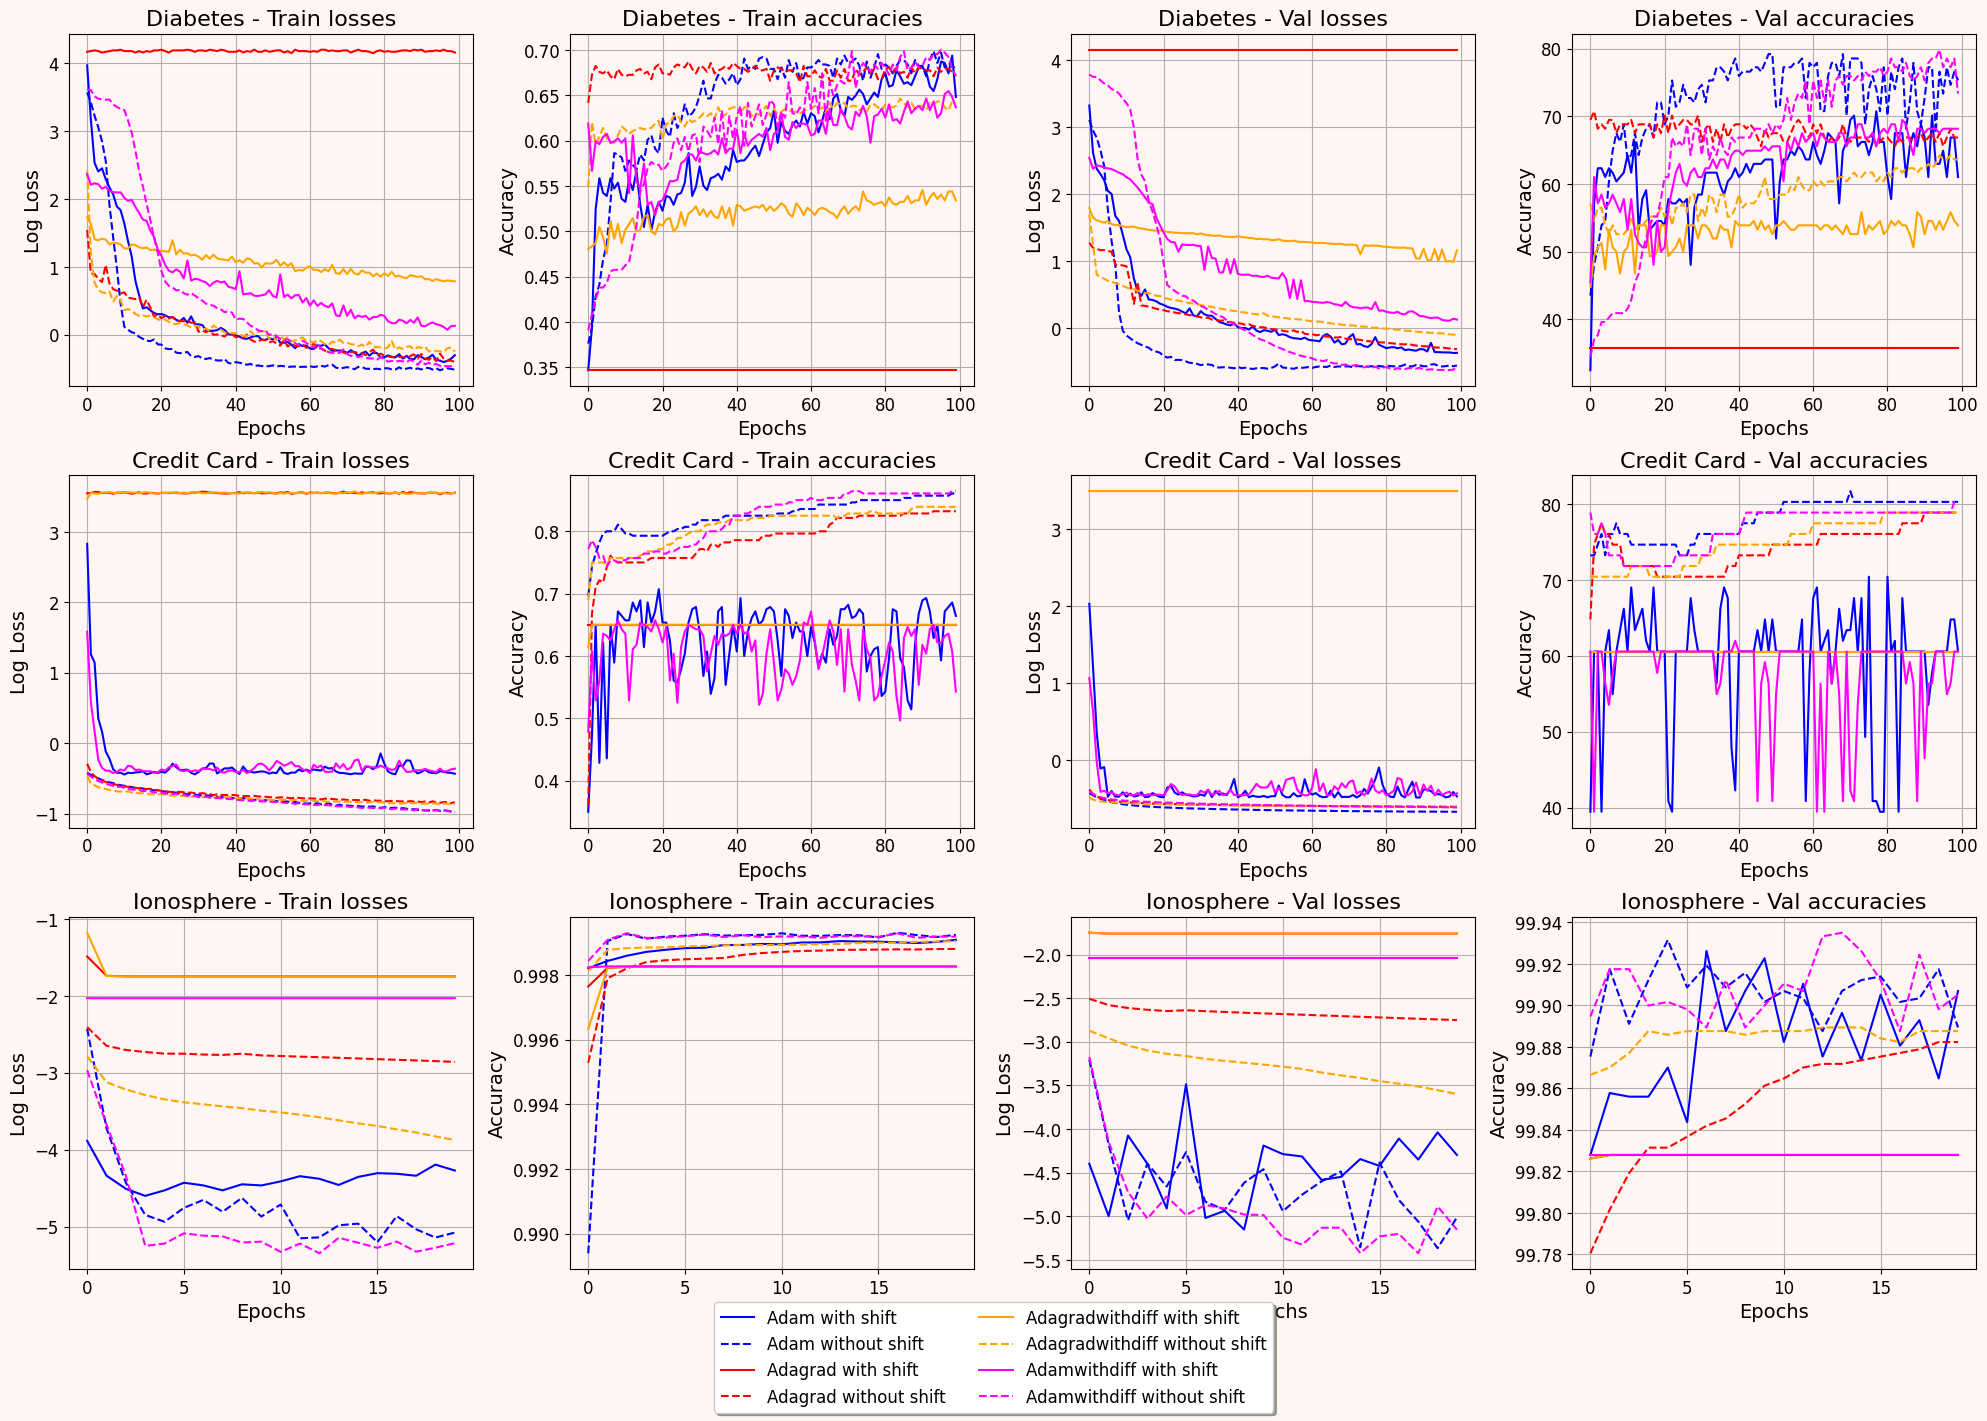

In [77]:
# Datasets and configurations
datasets = ['diabetes', 'ionosphere', 'creditcard']
data_types = ["train_losses", "train_accuracies", "val_losses", "val_accuracies"]
optimizers = ["adam", "adagrad", "adagradwithdiff", "adamwithdiff"]
shifts = ["with_shift", "without_shift"]
colors = {
    "adagrad": COLOR_ada,
    "adam": COLOR_adam,
    "adagradwithdiff": COLOR_adadiff,
    "adamwithdiff": COLOR_adamdiff
}
linestyles = {
    "with_shift": 'solid',
    "without_shift": 'dashed'
}

# Initialize a dictionary to hold the data
data = {dataset: {dtype: {opt: {shift: None for shift in shifts} for opt in optimizers} for dtype in data_types} for dataset in datasets}

# Load data using loops
for dataset in datasets:
    for dtype in data_types:
        for opt in optimizers:
            for shift in shifts:
                filename = f"./results/{dataset}_with_{opt}_{shift}_{dtype}.npy"
                data[dataset][dtype][opt][shift] = np.load(filename)

# Create 3x4 plots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), facecolor=(255/255, 245/255, 242/255))
plot_titles = ['Diabetes', 'Credit Card', 'Ionosphere']
y_labels = ['Log Loss', 'Accuracy', 'Log Loss', 'Accuracy']

lines_labels = []
for row, dataset in enumerate(datasets):
    for col, dtype in enumerate(data_types):
        ax = axs[row, col]
        ax.set_facecolor((255/255, 245/255, 242/255))
        for opt in optimizers:
            for shift in shifts:
                linestyle = linestyles[shift]
                color = colors[opt]
                label = f'{opt.capitalize()} {shift.replace("_", " ")}'
                if 'losses' in dtype:
                    line, = ax.plot(np.log(data[dataset][dtype][opt][shift]), label=label, color=color, linestyle=linestyle)
                else:
                    line, = ax.plot(data[dataset][dtype][opt][shift], label=label, color=color, linestyle=linestyle)
                if row == 0 and col == 0:  # Collect labels and lines for the first plot
                    lines_labels.append((line, label))
        ax.set_title(f'{plot_titles[row]} - {dtype.replace("_", " ").capitalize()}', fontsize=16)
        ax.set_xlabel('Epochs', fontsize=14)
        ax.set_ylabel(y_labels[col], fontsize=14)
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=12)

# Create a single legend for the entire figure
fig.legend(*zip(*lines_labels), loc='lower center', fontsize=12, frameon=True, shadow=True, ncol=2)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(bottom=0.10)  # Adjust bottom to make space for the legend
# Save the figure
# plt.savefig('training_validation_metrics_logistic_regr_1.png')
plt.show()

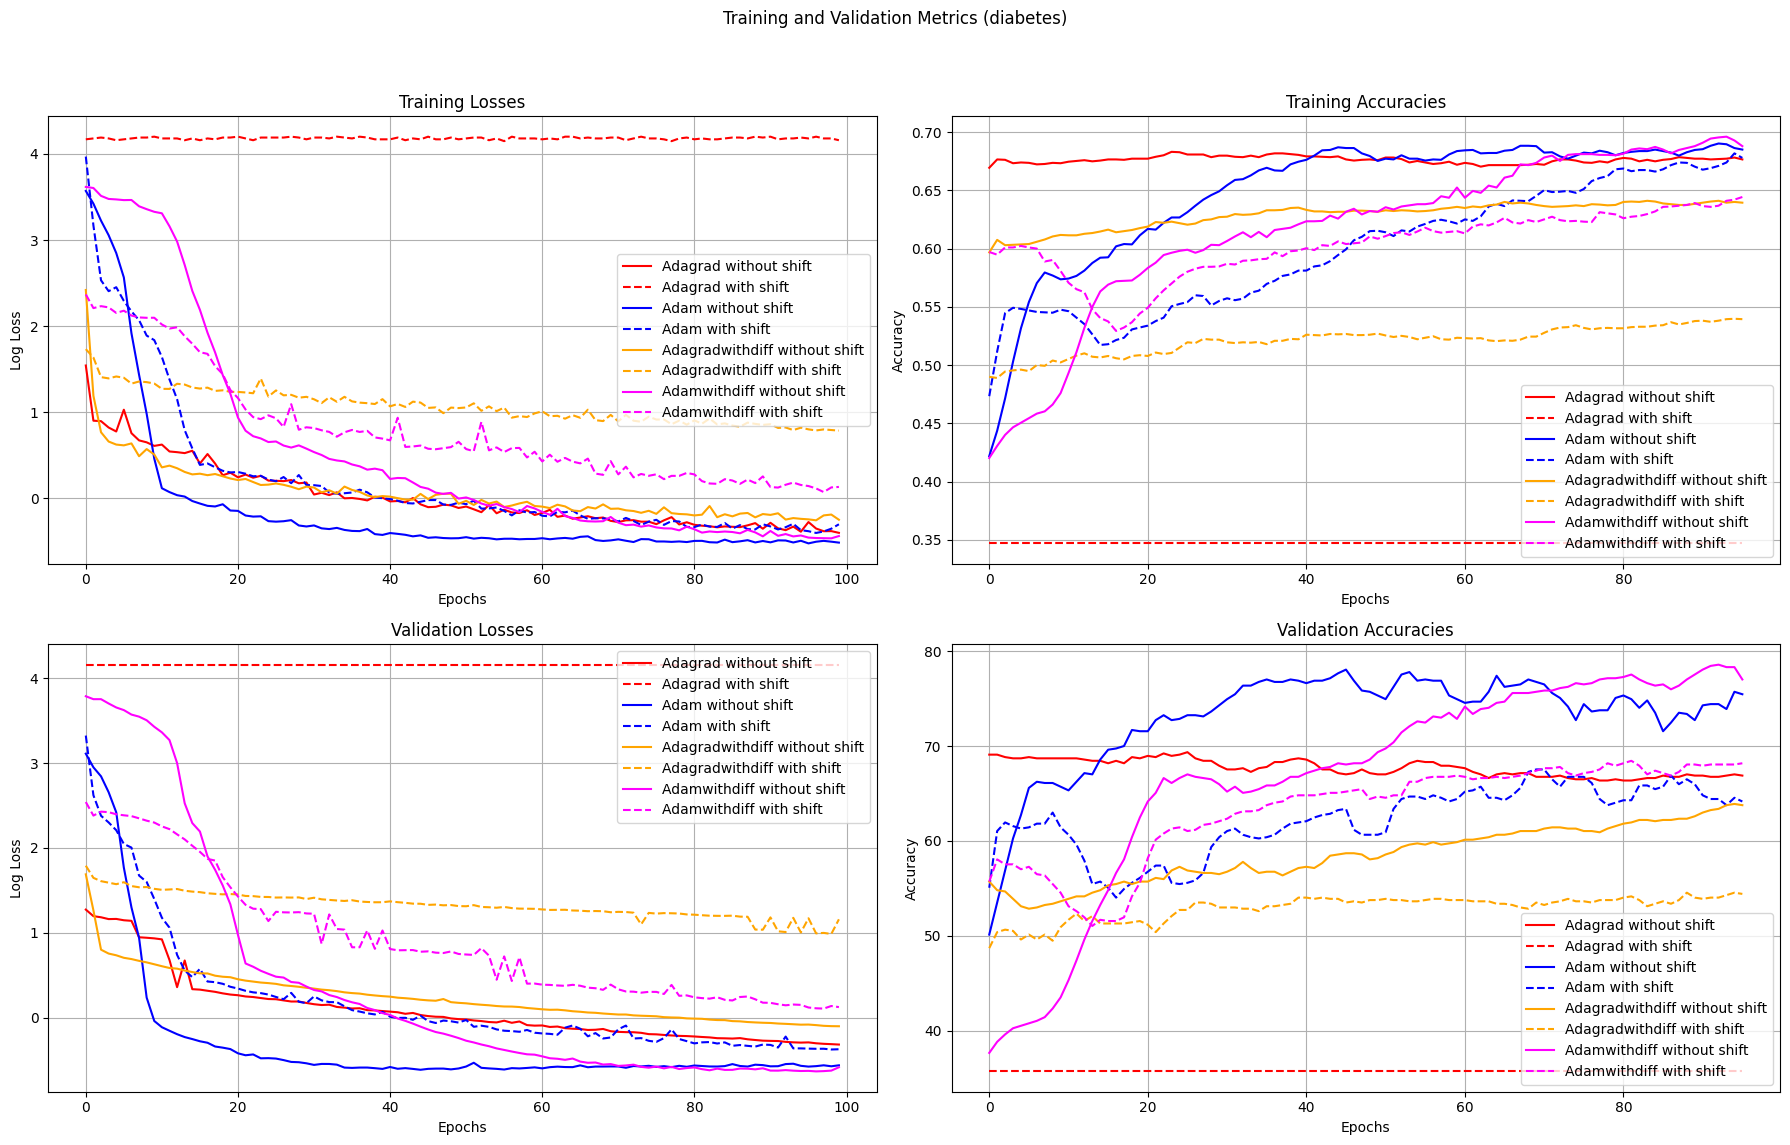

In [60]:
# Dataset and configurations
dataset = "diabetes"
data_types = ["train_losses", "train_accuracies", "val_losses", "val_accuracies"]
optimizers = ["adagrad", "adam", "adagradwithdiff", "adamwithdiff"]
shifts = ["without_shift", "with_shift"]
colors = {
    "adagrad": COLOR_ada,
    "adam": COLOR_adam,
    "adagradwithdiff": COLOR_adadiff,
    "adamwithdiff": COLOR_adamdiff
}
linestyles = {
    "without_shift": 'solid',
    "with_shift": 'dashed'
}

# Initialize a dictionary to hold the data
data = {dtype: {opt: {shift: None for shift in shifts} for opt in optimizers} for dtype in data_types}

# Load data using loops
for dtype in data_types:
    for opt in optimizers:
        for shift in shifts:
            filename = f"./results/{dataset}_with_{opt}_{shift}_{dtype}.npy"
            data[dtype][opt][shift] = np.load(filename)

# Create 2x2 plots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

plot_titles = ['Training Losses', 'Training Accuracies', 'Validation Losses', 'Validation Accuracies']
y_labels = ['Log Loss', 'Accuracy', 'Log Loss', 'Accuracy']

for i, dtype in enumerate(data_types):
    ax = axs[i // 2, i % 2]
    for opt in optimizers:
        for shift in shifts:
            linestyle = linestyles[shift]
            color = colors[opt]
            label = f'{opt.capitalize()} {shift.replace("_", " ")}'
            if 'losses' in dtype:
                ax.plot(np.log(data[dtype][opt][shift]), label=label, color=color, linestyle=linestyle)
            else:
                ax.plot(moving_average(data[dtype][opt][shift], 5), label=label, color=color, linestyle=linestyle)
    ax.set_title(plot_titles[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel(y_labels[i])
    ax.grid()
    ax.legend()

plt.suptitle(f'Training and Validation Metrics ({dataset})')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


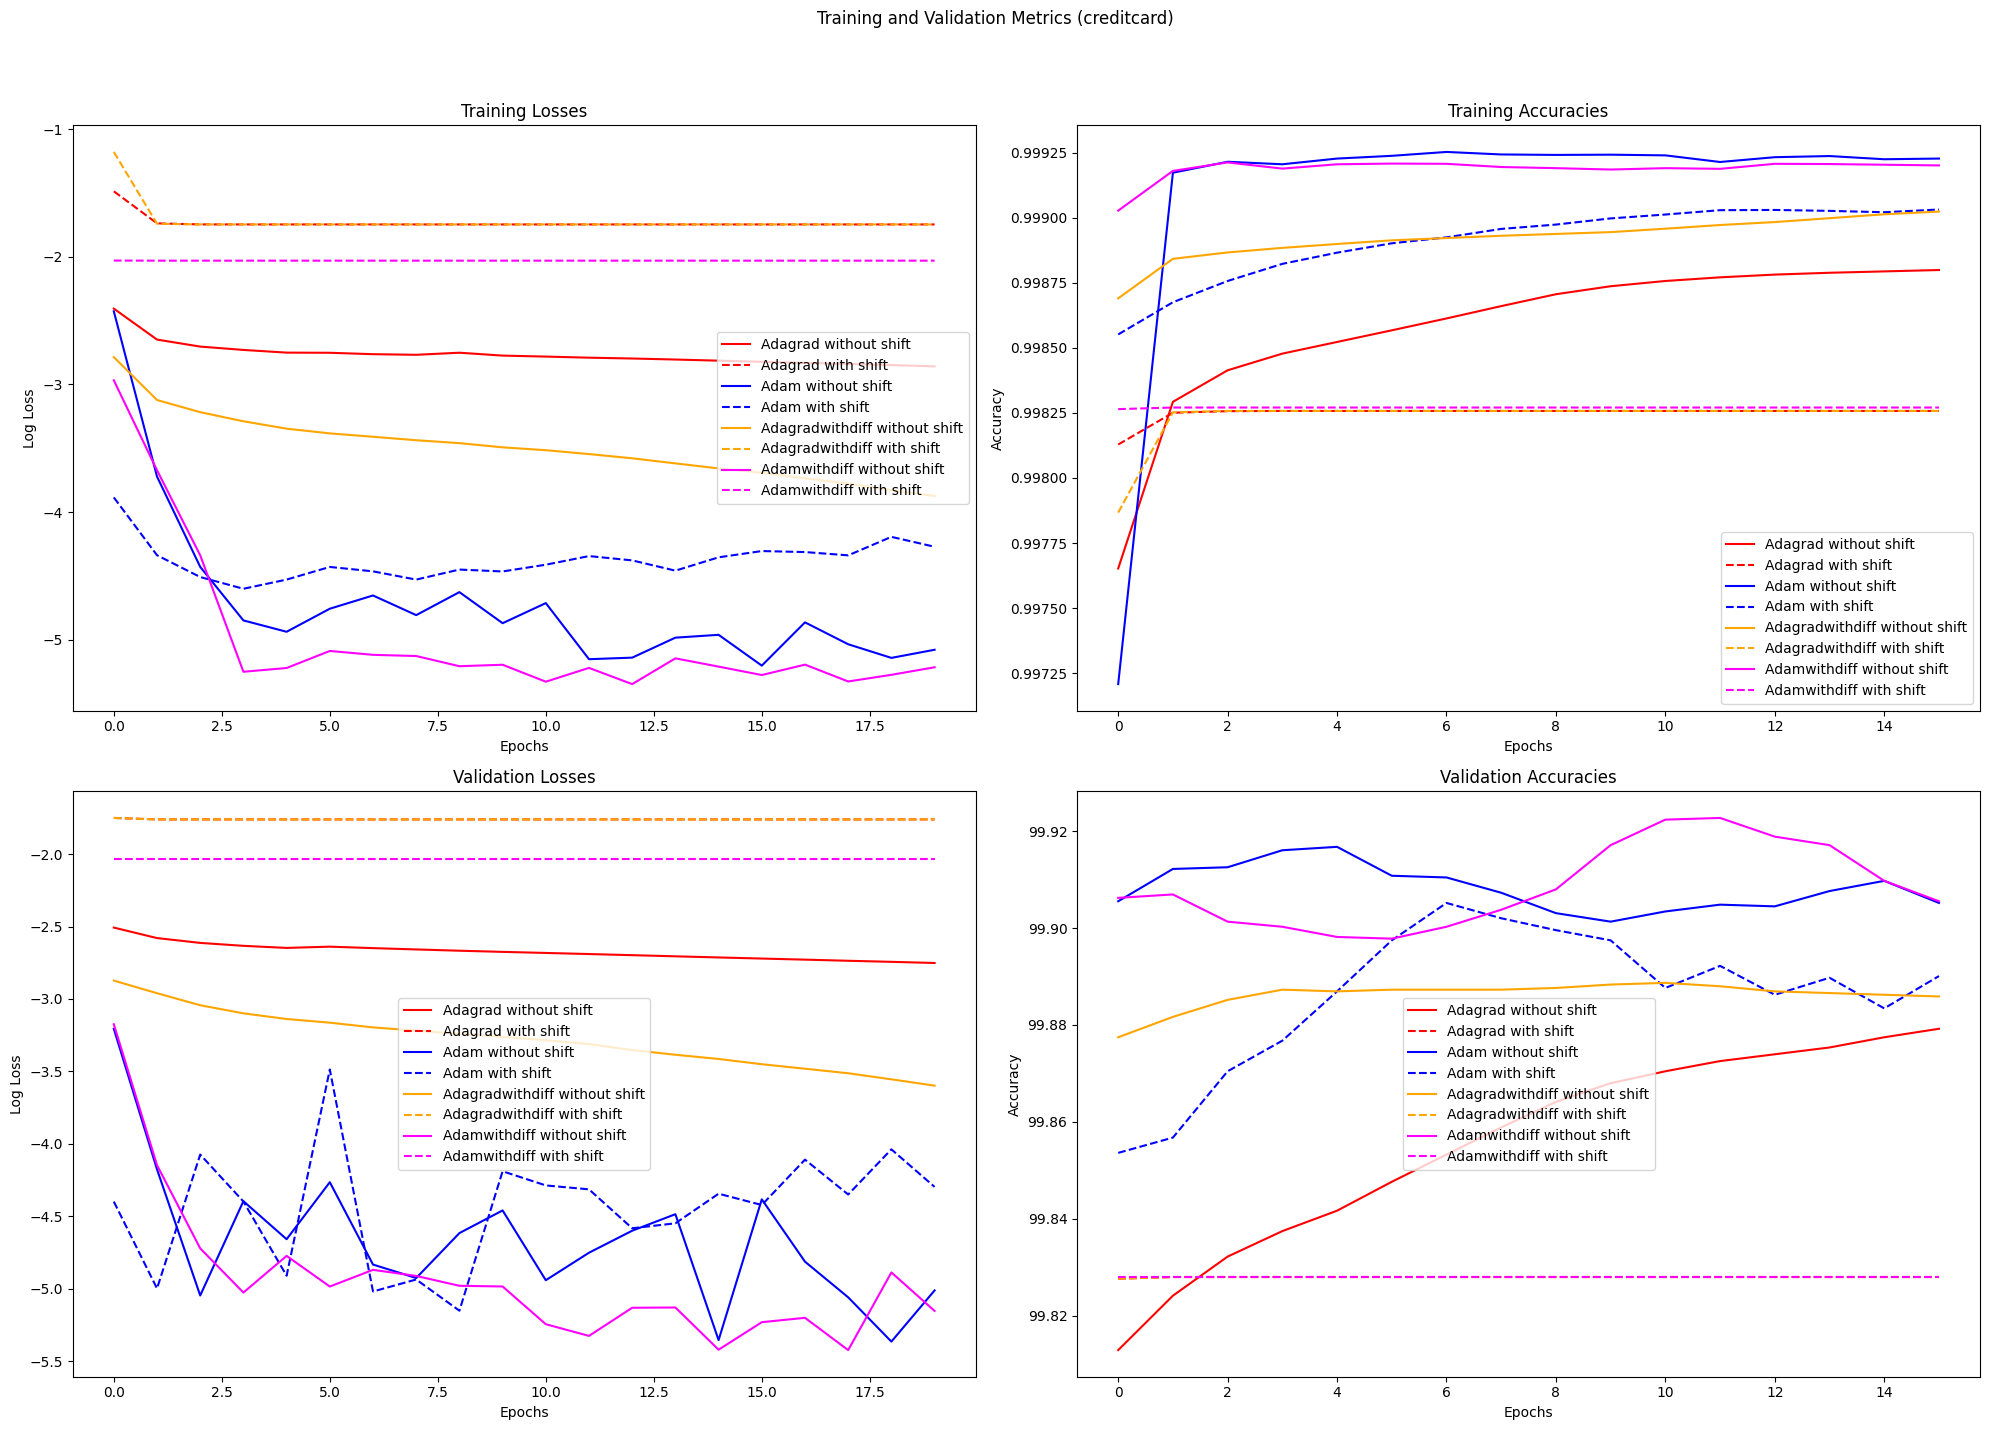

In [58]:
# Dataset and configurations
dataset = "creditcard"
data_types = ["train_losses", "train_accuracies", "val_losses", "val_accuracies"]
optimizers = ["adagrad", "adam", "adagradwithdiff", "adamwithdiff"]
shifts = ["without_shift", "with_shift"]
colors = {
    "adagrad": COLOR_ada,
    "adam": COLOR_adam,
    "adagradwithdiff": COLOR_adadiff,
    "adamwithdiff": COLOR_adamdiff
}
linestyles = {
    "without_shift": 'solid',
    "with_shift": 'dashed'
}

# Initialize a dictionary to hold the data
data = {dtype: {opt: {shift: None for shift in shifts} for opt in optimizers} for dtype in data_types}

# Load data using loops
for dtype in data_types:
    for opt in optimizers:
        for shift in shifts:
            filename = f"./results/{dataset}_with_{opt}_{shift}_{dtype}.npy"
            data[dtype][opt][shift] = np.load(filename)

# Create 2x2 plots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

plot_titles = ['Training Losses', 'Training Accuracies', 'Validation Losses', 'Validation Accuracies']
y_labels = ['Log Loss', 'Accuracy', 'Log Loss', 'Accuracy']

for i, dtype in enumerate(data_types):
    ax = axs[i // 2, i % 2]
    for opt in optimizers:
        for shift in shifts:
            linestyle = linestyles[shift]
            color = colors[opt]
            label = f'{opt.capitalize()} {shift.replace("_", " ")}'
            if 'losses' in dtype:
                ax.plot(np.log(data[dtype][opt][shift]), label=label, color=color, linestyle=linestyle)
            else:
                ax.plot(moving_average(data[dtype][opt][shift], 5), label=label, color=color, linestyle=linestyle)
    ax.set_title(plot_titles[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel(y_labels[i])
    ax.legend()

plt.suptitle(f'Training and Validation Metrics ({dataset})')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


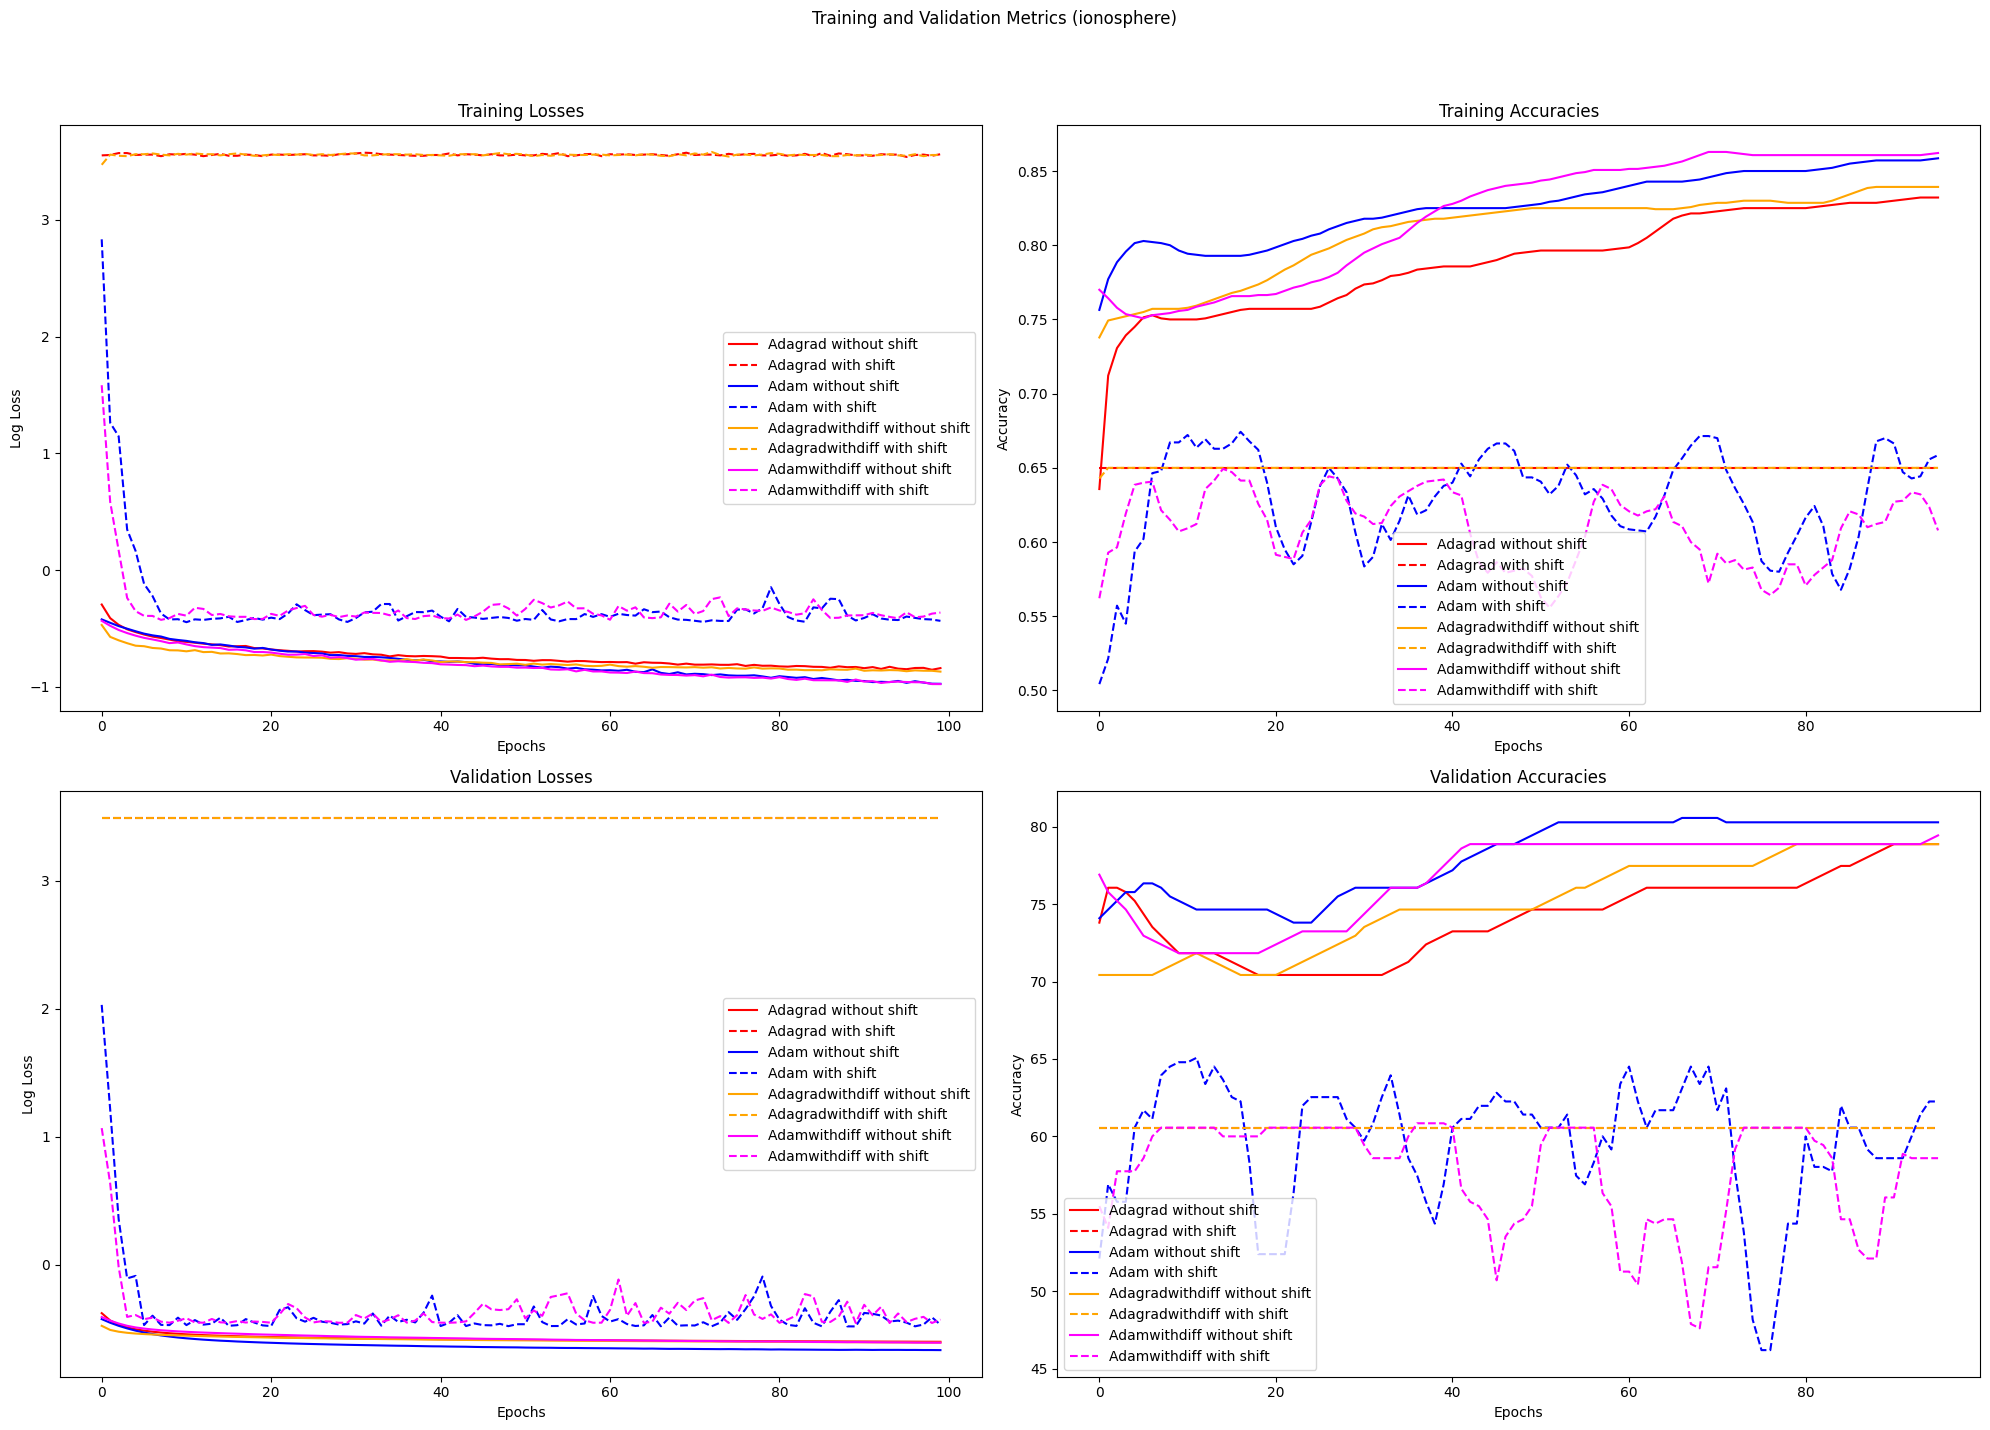

In [59]:
# Dataset and configurations
dataset = "ionosphere"
data_types = ["train_losses", "train_accuracies", "val_losses", "val_accuracies"]
optimizers = ["adagrad", "adam", "adagradwithdiff", "adamwithdiff"]
shifts = ["without_shift", "with_shift"]
colors = {
    "adagrad": COLOR_ada,
    "adam": COLOR_adam,
    "adagradwithdiff": COLOR_adadiff,
    "adamwithdiff": COLOR_adamdiff
}
linestyles = {
    "without_shift": 'solid',
    "with_shift": 'dashed'
}

# Initialize a dictionary to hold the data
data = {dtype: {opt: {shift: None for shift in shifts} for opt in optimizers} for dtype in data_types}

# Load data using loops
for dtype in data_types:
    for opt in optimizers:
        for shift in shifts:
            filename = f"./results/{dataset}_with_{opt}_{shift}_{dtype}.npy"
            data[dtype][opt][shift] = np.load(filename)

# Create 2x2 plots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

plot_titles = ['Training Losses', 'Training Accuracies', 'Validation Losses', 'Validation Accuracies']
y_labels = ['Log Loss', 'Accuracy', 'Log Loss', 'Accuracy']

for i, dtype in enumerate(data_types):
    ax = axs[i // 2, i % 2]
    for opt in optimizers:
        for shift in shifts:
            linestyle = linestyles[shift]
            color = colors[opt]
            label = f'{opt.capitalize()} {shift.replace("_", " ")}'
            if 'losses' in dtype:
                ax.plot(np.log(data[dtype][opt][shift]), label=label, color=color, linestyle=linestyle)
            else:
                ax.plot(moving_average(data[dtype][opt][shift], 5), label=label, color=color, linestyle=linestyle)
    ax.set_title(plot_titles[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel(y_labels[i])
    ax.legend()

plt.suptitle(f'Training and Validation Metrics ({dataset})')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### MNIST

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(0)

# Define the Logistic Regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        out = self.linear(x)
        return out

# Function to load MNIST dataset and create DataLoader
def load_mnist(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Function to train the model with timing measurement
def train(model, optimizer, criterion, train_loader, num_epochs):
    epoch_times = []
    losses = []
    total_time_start = time.time()

    model.train()
    for epoch in range(num_epochs):
        epoch_start = time.time()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_end = time.time()

        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)

        epoch_time = epoch_end - epoch_start
        epoch_times.append(epoch_time)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {epoch_time:.2f} s')

    total_time_end = time.time()
    total_training_time = total_time_end - total_time_start
    print(f'Total training time: {total_training_time:.2f} s')

    return losses, epoch_times, total_training_time

# Function to evaluate the model with timing measurement
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    eval_start = time.time()

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    eval_end = time.time()
    eval_time = eval_end - eval_start

    accuracy = correct / total * 100
    print(f'Accuracy on the test set: {accuracy:.2f}%, Evaluation time: {eval_time:.2f} s')

    return accuracy, eval_time

In [ ]:
# Define constants
input_size = 28 * 28  # MNIST image size is 28x28
num_classes = 10  # 10 digits (0-9)
batch_size = 64
learning_rate = 0.001
num_epochs = 20

# Load MNIST data
train_loader, test_loader = load_mnist(batch_size)

# Initialize models
model_standard = LogisticRegression(input_size, num_classes)
model_custom = LogisticRegression(input_size, num_classes)

# Define criteria and optimizers
criterion = nn.CrossEntropyLoss()

optimizer_standard = optim.Adam(model_standard.parameters(), lr=learning_rate)
optimizer_custom = AdamWithDiff(model_custom.parameters(), lr=learning_rate)

# Train with standard Adam optimizer
print("\nTraining with Standard Adam Optimizer:")
train_losses_standard, epoch_times_standard, convergence_time_standard = train(model_standard, optimizer_standard, criterion, train_loader, num_epochs)

# Evaluate with standard Adam optimizer
test_accuracy_standard, eval_time_standard = evaluate(model_standard, test_loader)

# Train with custom AdamWithDiff optimizer
print("\nTraining with Custom AdamWithDiff Optimizer:")
train_losses_custom, epoch_times_custom, convergence_time_custom = train(model_custom, optimizer_custom, criterion, train_loader, num_epochs)

# Evaluate with custom AdamWithDiff optimizer
test_accuracy_custom, eval_time_custom = evaluate(model_custom, test_loader)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16431885.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 491705.95it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3938921.49it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4242879.46it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


Training with Standard Adam Optimizer:
Epoch [1/20], Loss: 0.4696, Time: 15.72 s
Epoch [2/20], Loss: 0.3266, Time: 14.88 s
Epoch [3/20], Loss: 0.3100, Time: 15.49 s
Epoch [4/20], Loss: 0.3022, Time: 15.00 s
Epoch [5/20], Loss: 0.2950, Time: 15.74 s
Epoch [6/20], Loss: 0.2901, Time: 15.28 s
Epoch [7/20], Loss: 0.2870, Time: 14.98 s
Epoch [8/20], Loss: 0.2851, Time: 14.81 s
Epoch [9/20], Loss: 0.2821, Time: 14.74 s
Epoch [10/20], Loss: 0.2809, Time: 17.96 s
Epoch [11/20], Loss: 0.2775, Time: 25.12 s
Epoch [12/20], Loss: 0.2765, Time: 17.78 s
Epoch [13/20], Loss: 0.2750, Time: 18.40 s
Epoch [14/20], Loss: 0.2731, Time: 15.03 s
Epoch [15/20], Loss: 0.2740, Time: 14.92 s
Epoch [16/20], Loss: 0.2721, Time: 14.84 s
Epoch [17/20], Loss: 0.2715, Time: 14.93 s
Epoch [18/20], Loss: 0.2696, Time: 16.00 s
Epoch [19/20], Loss: 0.2671, Time: 15.20 s
Epoch [20/20], Loss: 0.2685, Time: 14.76 s
Total training time: 321.62 s
Accu

<ipython-input-3-b8ac5718c6bb>:86: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1578.)
  m.mul_(beta1).add_(1 - beta1, grad)


Epoch [1/20], Loss: 0.4661, Time: 14.70 s
Epoch [2/20], Loss: 0.3281, Time: 17.72 s
Epoch [3/20], Loss: 0.3102, Time: 15.05 s
Epoch [4/20], Loss: 0.2990, Time: 14.86 s
Epoch [5/20], Loss: 0.2929, Time: 15.05 s
Epoch [6/20], Loss: 0.2910, Time: 16.46 s
Epoch [7/20], Loss: 0.2856, Time: 14.90 s
Epoch [8/20], Loss: 0.2806, Time: 14.89 s
Epoch [9/20], Loss: 0.2797, Time: 15.09 s
Epoch [10/20], Loss: 0.2781, Time: 15.01 s
Epoch [11/20], Loss: 0.2764, Time: 15.47 s
Epoch [12/20], Loss: 0.2742, Time: 14.77 s
Epoch [13/20], Loss: 0.2724, Time: 14.76 s
Epoch [14/20], Loss: 0.2716, Time: 14.83 s
Epoch [15/20], Loss: 0.2710, Time: 15.02 s
Epoch [16/20], Loss: 0.2687, Time: 15.47 s
Epoch [17/20], Loss: 0.2673, Time: 14.83 s
Epoch [18/20], Loss: 0.2668, Time: 14.76 s
Epoch [19/20], Loss: 0.2668, Time: 14.81 s
Epoch [20/20], Loss: 0.2652, Time: 14.96 s
Total training time: 303.42 s
Accuracy on the test set: 92.15%, Evaluation time: 2.78 s


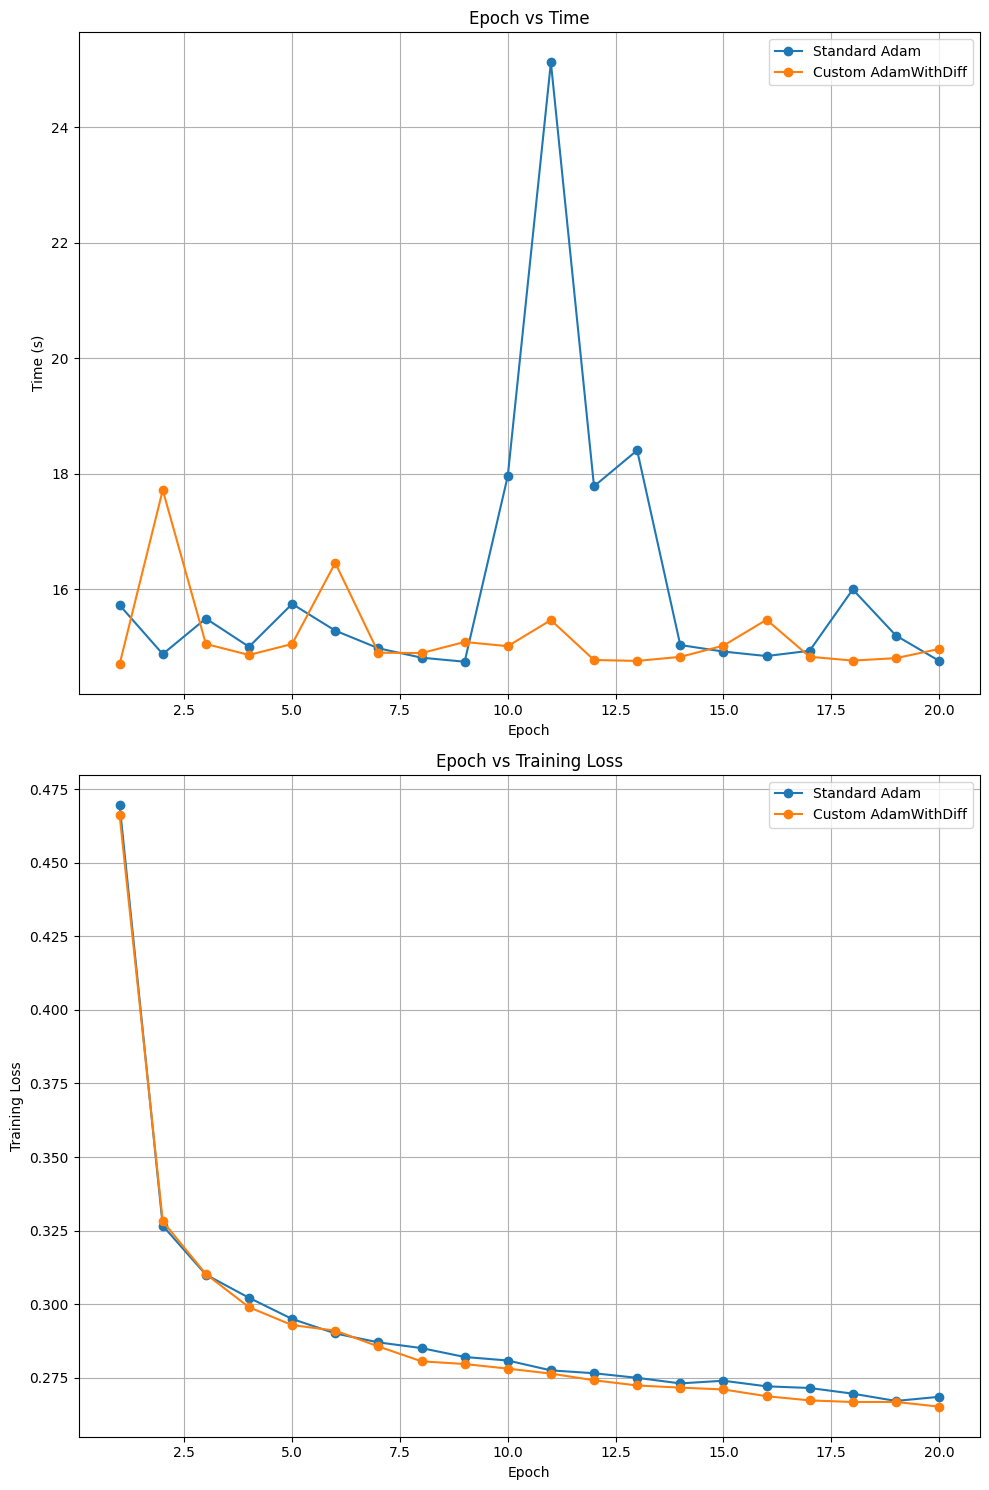


Convergence Time:
Standard Adam: 321.62 s
Custom AdamWithDiff: 303.42 s


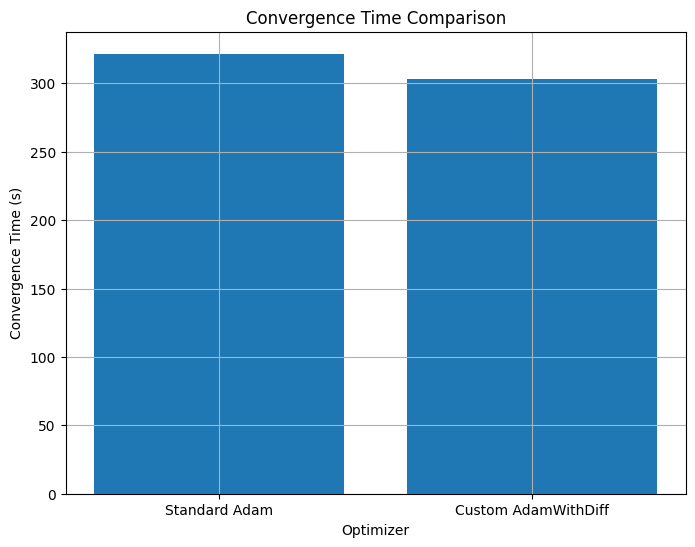

In [ ]:
# Plot epoch vs time
plt.figure(figsize=(10, 15))

plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), epoch_times_standard, 'o-', label='Standard Adam')
plt.plot(range(1, num_epochs + 1), epoch_times_custom, 'o-', label='Custom AdamWithDiff')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.title('Epoch vs Time')
plt.legend()
plt.grid(True)

# Plot epoch vs train loss
plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), train_losses_standard, 'o-', label='Standard Adam')
plt.plot(range(1, num_epochs + 1), train_losses_custom, 'o-', label='Custom AdamWithDiff')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Epoch vs Training Loss')
plt.legend()
plt.grid(True)

# Plot epoch vs test accuracy
# plt.subplot(3, 1, 3)
# plt.plot(range(1, num_epochs + 1), [test_accuracy_standard] * num_epochs, label='Standard Adam')
# plt.plot(range(1, num_epochs + 1), [test_accuracy_custom] * num_epochs, label='Custom AdamWithDiff')
# plt.xlabel('Epoch')
# plt.ylabel('Test Accuracy (%)')
# plt.title('Epoch vs Test Accuracy')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()

# Print and plot convergence time
print(f'\nConvergence Time:')
print(f'Standard Adam: {convergence_time_standard:.2f} s')
print(f'Custom AdamWithDiff: {convergence_time_custom:.2f} s')

plt.figure(figsize=(8, 6))
plt.bar(['Standard Adam', 'Custom AdamWithDiff'], [convergence_time_standard, convergence_time_custom])
plt.xlabel('Optimizer')
plt.ylabel('Convergence Time (s)')
plt.title('Convergence Time Comparison')
plt.grid(True)
plt.show()

In [ ]:
# Define constants
input_size = 28 * 28  # MNIST image size is 28x28
num_classes = 10  # 10 digits (0-9)
batch_size = 64
learning_rate = 0.001
num_epochs = 20

# Load MNIST data
train_loader, test_loader = load_mnist(batch_size)

# Initialize models
model_standard = LogisticRegression(input_size, num_classes)
model_custom = LogisticRegression(input_size, num_classes)

# Define criteria and optimizers
criterion = nn.CrossEntropyLoss()

optimizer_standard = optim.Adagrad(model_standard.parameters(), lr=learning_rate)
optimizer_custom = AdaGradWithDiff(model_custom.parameters(), lr=learning_rate)

# Train with standard Adagrad optimizer
print("\nTraining with Standard Adagrad Optimizer:")
train_losses_standard, epoch_times_standard, convergence_time_standard = train(model_standard, optimizer_standard, criterion, train_loader, num_epochs)

# Evaluate with standard Adagrad optimizer
test_accuracy_standard, eval_time_standard = evaluate(model_standard, test_loader)

# Train with custom AdaGradWithDiff optimizer
print("\nTraining with Custom AdaGradWithDiff Optimizer:")
train_losses_custom, epoch_times_custom, convergence_time_custom = train(model_custom, optimizer_custom, criterion, train_loader, num_epochs)

# Evaluate with custom AdaGradWithDiff optimizer
test_accuracy_custom, eval_time_custom = evaluate(model_custom, test_loader)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 36795432.62it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1256946.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9930604.43it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2265762.22it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




Training with Standard Adagrad Optimizer:
Epoch [1/20], Loss: 1.0471, Time: 16.60 s
Epoch [2/20], Loss: 0.6917, Time: 16.61 s
Epoch [3/20], Loss: 0.6018, Time: 16.17 s
Epoch [4/20], Loss: 0.5540, Time: 15.78 s
Epoch [5/20], Loss: 0.5229, Time: 16.13 s
Epoch [6/20], Loss: 0.5006, Time: 16.50 s
Epoch [7/20], Loss: 0.4836, Time: 16.87 s
Epoch [8/20], Loss: 0.4701, Time: 15.95 s
Epoch [9/20], Loss: 0.4589, Time: 16.80 s
Epoch [10/20], Loss: 0.4497, Time: 16.44 s
Epoch [11/20], Loss: 0.4417, Time: 15.78 s
Epoch [12/20], Loss: 0.4347, Time: 16.07 s
Epoch [13/20], Loss: 0.4286, Time: 16.81 s
Epoch [14/20], Loss: 0.4231, Time: 16.08 s
Epoch [15/20], Loss: 0.4182, Time: 16.78 s
Epoch [16/20], Loss: 0.4139, Time: 16.93 s
Epoch [17/20], Loss: 0.4098, Time: 16.05 s
Epoch [18/20], Loss: 0.4062, Time: 15.97 s
Epoch [19/20], Loss: 0.4027, Time: 15.96 s
Epoch [20/20], Loss: 0.3996, Time: 16.92 s
Total training time: 327.20 s
Accuracy on the test set: 89.83%, Evaluation time: 2.31 s

Training with Cus

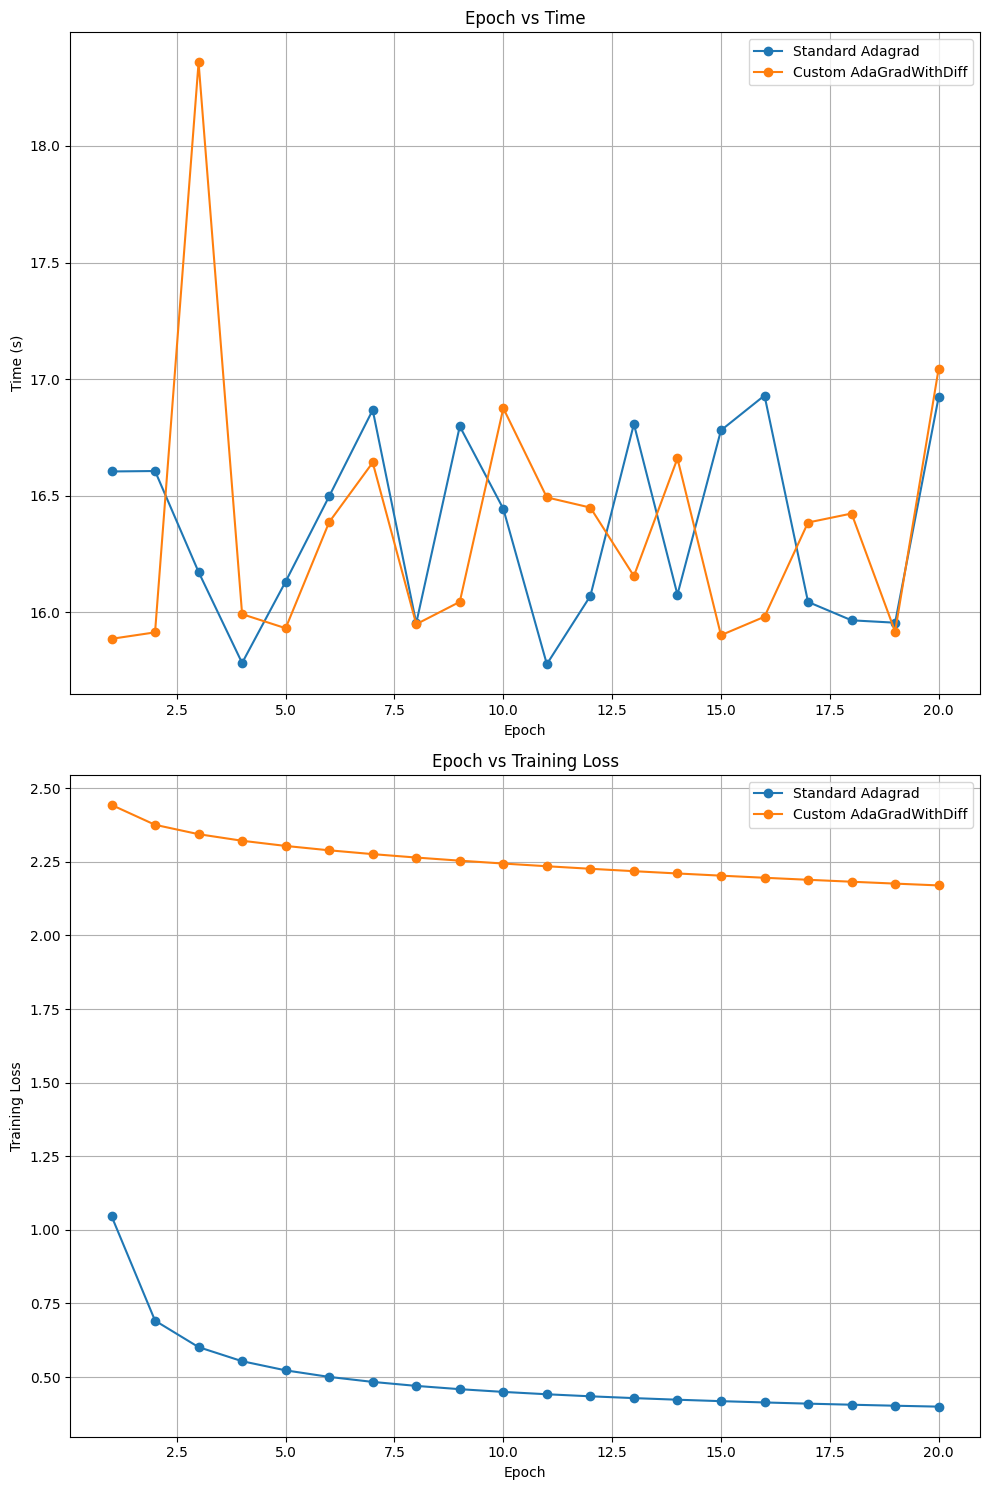


Convergence Time:
Standard Adagrad: 327.20 s
Custom AdaGradWithDiff: 327.41 s


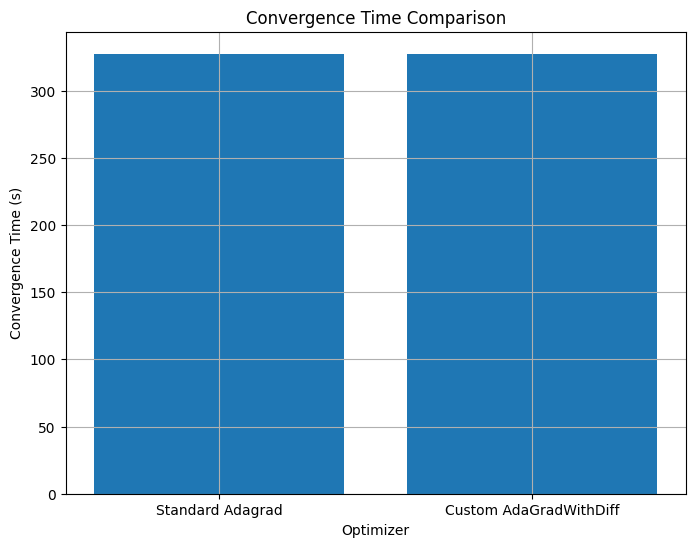

In [ ]:
# Plot epoch vs time
plt.figure(figsize=(10, 15))

plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), epoch_times_standard, 'o-', label='Standard Adagrad')
plt.plot(range(1, num_epochs + 1), epoch_times_custom, 'o-', label='Custom AdaGradWithDiff')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.title('Epoch vs Time')
plt.legend()
plt.grid(True)

# Plot epoch vs train loss
plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), train_losses_standard, 'o-', label='Standard Adagrad')
plt.plot(range(1, num_epochs + 1), train_losses_custom, 'o-', label='Custom AdaGradWithDiff')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Epoch vs Training Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print and plot convergence time
print(f'\nConvergence Time:')
print(f'Standard Adagrad: {convergence_time_standard:.2f} s')
print(f'Custom AdaGradWithDiff: {convergence_time_custom:.2f} s')

plt.figure(figsize=(8, 6))
plt.bar(['Standard Adagrad', 'Custom AdaGradWithDiff'], [convergence_time_standard, convergence_time_custom])
plt.xlabel('Optimizer')
plt.ylabel('Convergence Time (s)')
plt.title('Convergence Time Comparison')
plt.grid(True)
plt.show()

### Testing on simple functions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
# from mpl_toolkits.mplot3d import Axes3D

# %matplotlib widget

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# parameters
NO_ITERS = 50
LR_RATE = 0.1
BETA1 = 0.95
BETA2 = 0.999
EPS = 0.00000001

In [ ]:
class AdaGrad(object):
    def __init__(self, lr, eps):
        self.lr = lr
        self.eps = eps
        self.t = 0

    def update(self, x, g):
        self.t += 1
        x_t = x - (self.lr * g) / (np.sqrt(g ** 2) + self.eps)
        return x_t

class AdaGradWithDiff_v1(object):
    def __init__(self, lr, eps):
        self.lr = lr
        self.eps = eps
        self.t = 0
        self.prev_g = 0.0

    def update(self, x, g):
        self.t +=1
        diff_g = np.abs(g - self.prev_g)
        x_t = x - (self.lr * g) / (np.sqrt(diff_g ** 2) + self.eps)
        self.prev_g = g
        return x_t

In [ ]:
class Adam(object):
    def __init__(self, lr, beta1, beta2, eps):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.m = 0.0 # 1st order
        self.v = 0.0 # 2nd order

    def update(self, x, g):
        self.t += 1
        self.m = self.beta1 * self.m + (1.0 - self.beta1) * g
        self.v = self.beta2 * self.v + (1.0 - self.beta2) * g ** 2
        m_adj = self.m / (1.0 - np.power(self.beta1, self.t))
        v_adj = self.v / (1.0 - np.power(self.beta2, self.t))
        x_t = x - self.lr * m_adj / (np.sqrt(v_adj) + self.eps)
        return x_t

class AdamWithDiff_v1(object):
    def __init__(self, lr, beta1, beta2, eps):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.m = 0.0 # 1st order
        self.v = 0.0 # 2nd order
        self.prev_g = 0.0

    def update(self, x, g):
        self.t += 1
        diff_g = np.abs(g - self.prev_g)
        self.m = self.beta1 * self.m + (1.0 - self.beta1) * g
        self.v = self.beta2 * self.v + (1.0 - self.beta2) * diff_g ** 2
        m_adj = self.m / (1.0 - np.power(self.beta1, self.t))
        v_adj = self.v / (1.0 - np.power(self.beta2, self.t))
        x_t = x - self.lr * m_adj / (np.sqrt(v_adj) + self.eps)
        self.prev_g = g
        return x_t

In [ ]:
# Functions and their gradients
def fun1(x):
    if x <= 0:
        return (x + 0.3)*(x + 0.3)
    else:
        return (x - 0.2)*(x - 0.2) + 0.05

def calc_grad_fun1(x):
    if x <= 0:
        return 2*x + 0.6
    else:
        return 2*x - 0.4

def fun2(x):
    if x <= -0.9:
        return -40 * x - 35.15
    else:
        return x ** 3 - x * math.sin(8 * x) + 0.85

def calc_grad_fun2(x):
    if x <= -0.9:
        return -40
    else:
        return x * math.cos(8 * x) + math.sin(8 * x) + 3 * x * x

def fun3(x):
    if x <= -0.5:
        return x**2
    elif x <= -0.4:
        return x + 0.75
    elif x <= 0:
        return -7/8 * x
    elif x <= 0.4:
        return 7/8 * x
    elif x <= 0.5:
        return -x + 0.75
    else:
        return x**2

def calc_grad_fun3(x):
    if x <= -0.5:
        return 2 * x
    elif x <= -0.4:
        return 1.0
    elif x <= 0.0:
        return -7/8
    elif x <= 0.4:
        return 7/8
    elif x <= 0.5:
        return -1.0
    else:
        return 2 * x

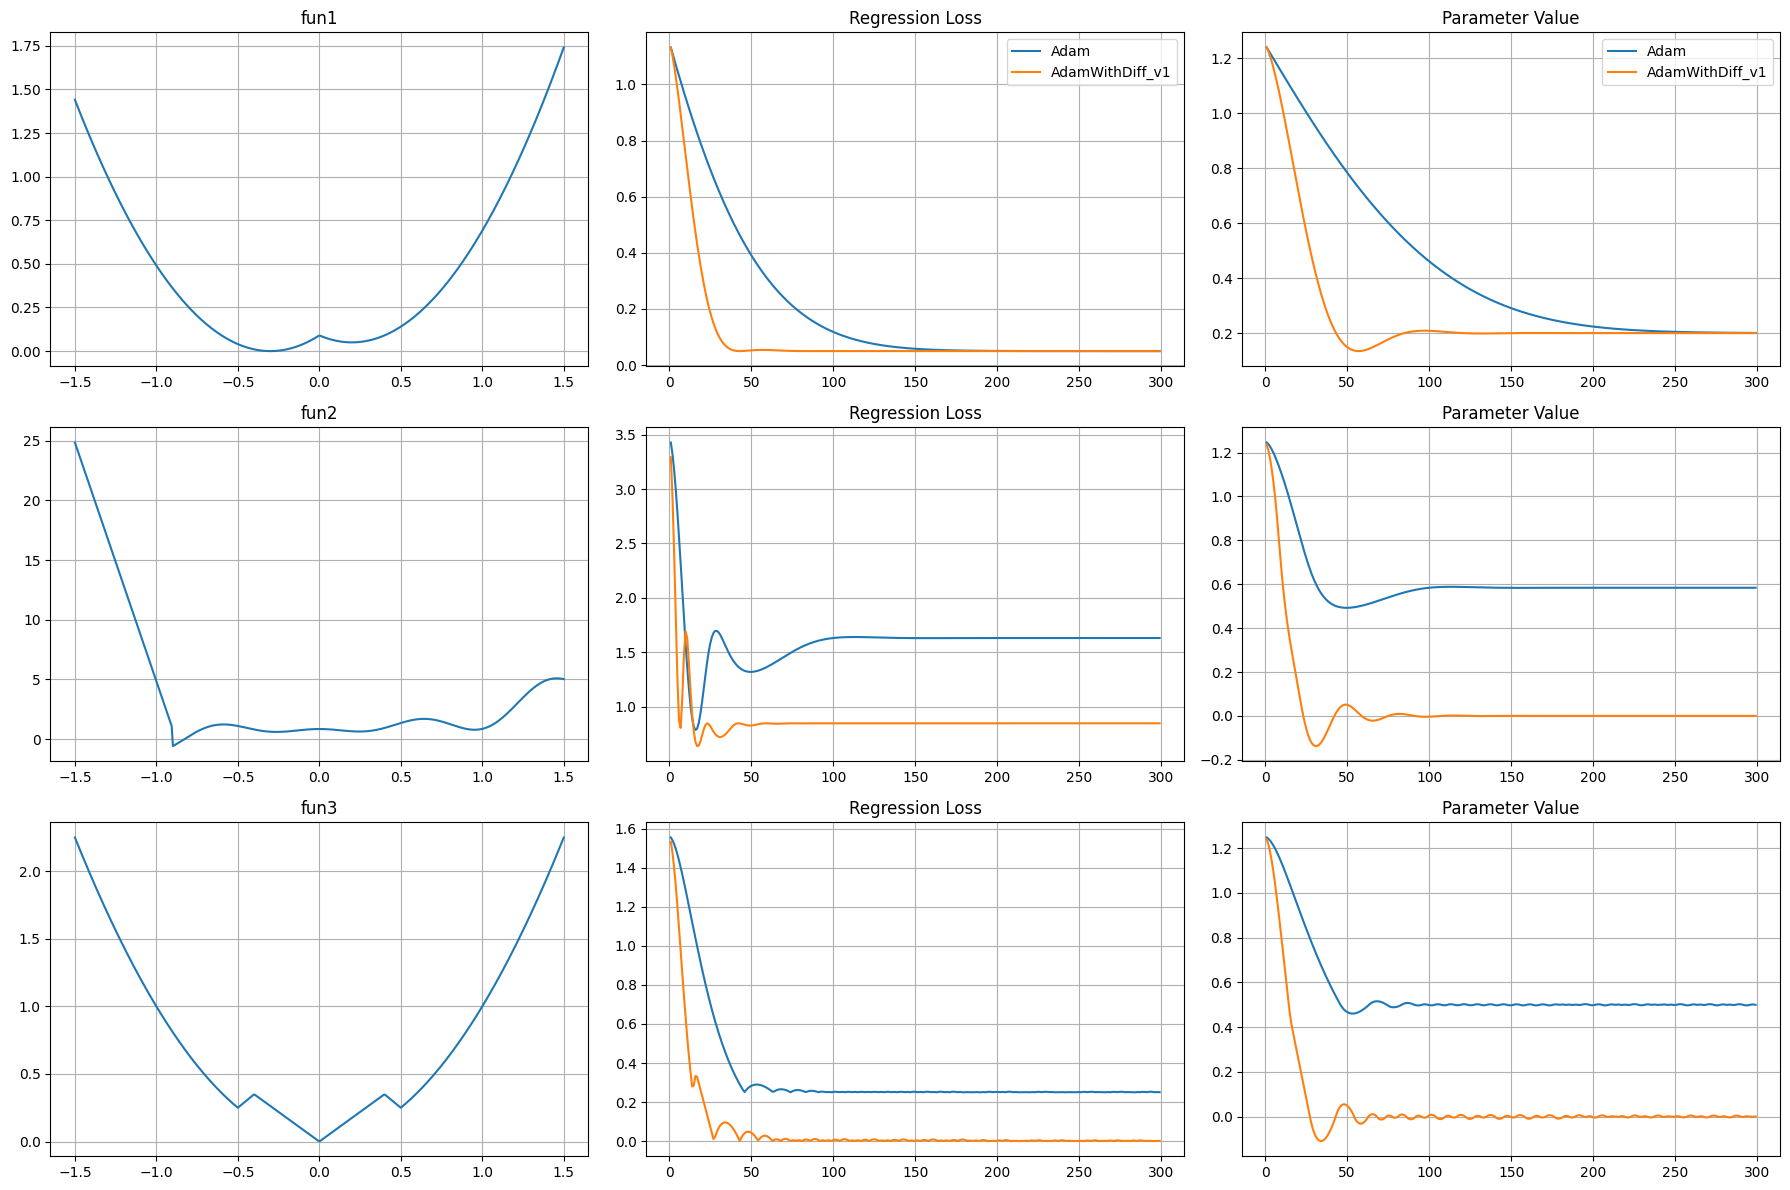

In [ ]:
# Solve function
def solve(fun, calc_grad, x0, solver, nb_iters):
    x = np.zeros(nb_iters)
    y = np.zeros(nb_iters)
    grad_norm = np.zeros(nb_iters)
    grad_diff = np.zeros(nb_iters)
    prev_grad = 0
    x[0] = x0
    for idx_iter in range(1, nb_iters):
        g = calc_grad(x[idx_iter - 1])
        x[idx_iter] = solver.update(x[idx_iter - 1], g)
        y[idx_iter] = fun(x[idx_iter])
        grad_norm[idx_iter] = np.abs(g)
        grad_diff[idx_iter] = np.abs(g - prev_grad)
        prev_grad = g
    return x, y

def get_grads(fun, calc_grad, x0, nb_iters):
    x = np.zeros(nb_iters)
    grad_norm = np.zeros(nb_iters)
    grad_diff = np.zeros(nb_iters)
    prev_grad = 0
    x[0] = x0
    for idx_iter in range(1, nb_iters):
        g = calc_grad(x[idx_iter - 1])
        grad_norm[idx_iter] = np.abs(g)
        grad_diff[idx_iter] = np.abs(g - prev_grad)
        prev_grad = g
    return grad_norm, grad_diff

# Parameters
lrn_rate = 0.01
beta1 = 0.9
beta2 = 0.999
eps = 1e-8
nb_iters = 300

# Initial point
x0 = 1.25

# Functions and their gradients
functions = [(fun1, calc_grad_fun1, 'fun1'), (fun2, calc_grad_fun2, 'fun2'), (fun3, calc_grad_fun3, 'fun3')]

# Optimizers
optimizers = [
    # ('AdaGrad', AdaGrad(lrn_rate, eps)),
    # ('AdaGradWithDiff_v1', AdaGradWithDiff_v1(lrn_rate, eps)),
    ('Adam', Adam(lrn_rate, beta1, beta2, eps)),
    ('AdamWithDiff_v1', AdamWithDiff_v1(lrn_rate, beta1, beta2, eps))
]

# Plotting
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = [18.0, 12.0]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for row, (fun, calc_grad, fun_name) in enumerate(functions):
    # Plot the function itself
    x_vals = np.linspace(-1.5, 1.5, 400)
    y_vals = np.array([fun(x) for x in x_vals])
    axes[row, 0].plot(x_vals, y_vals)
    axes[row, 0].set_title(f'{fun_name}')
    axes[row, 0].grid()

    for col, (opt_name, solver) in enumerate(optimizers):
        x, y = solve(fun, calc_grad, x0, solver, nb_iters)

        # Plot iteration vs regression loss
        axes[row, 1].plot(np.arange(nb_iters - 1) + 1, y[1:], label=f'{opt_name}')
        axes[row, 1].set_title(f'Regression Loss')

        # Plot iteration vs Parameter Value
        axes[row, 2].plot(np.arange(nb_iters - 1) + 1, x[1:], label=f'{opt_name}')
        axes[row, 2].set_title(f'Parameter Value')

    axes[row, 1].grid()
    axes[row, 2].grid()

# Add legends
for col in range(1, 3):
    axes[0, col].legend()

plt.tight_layout()
plt.show()

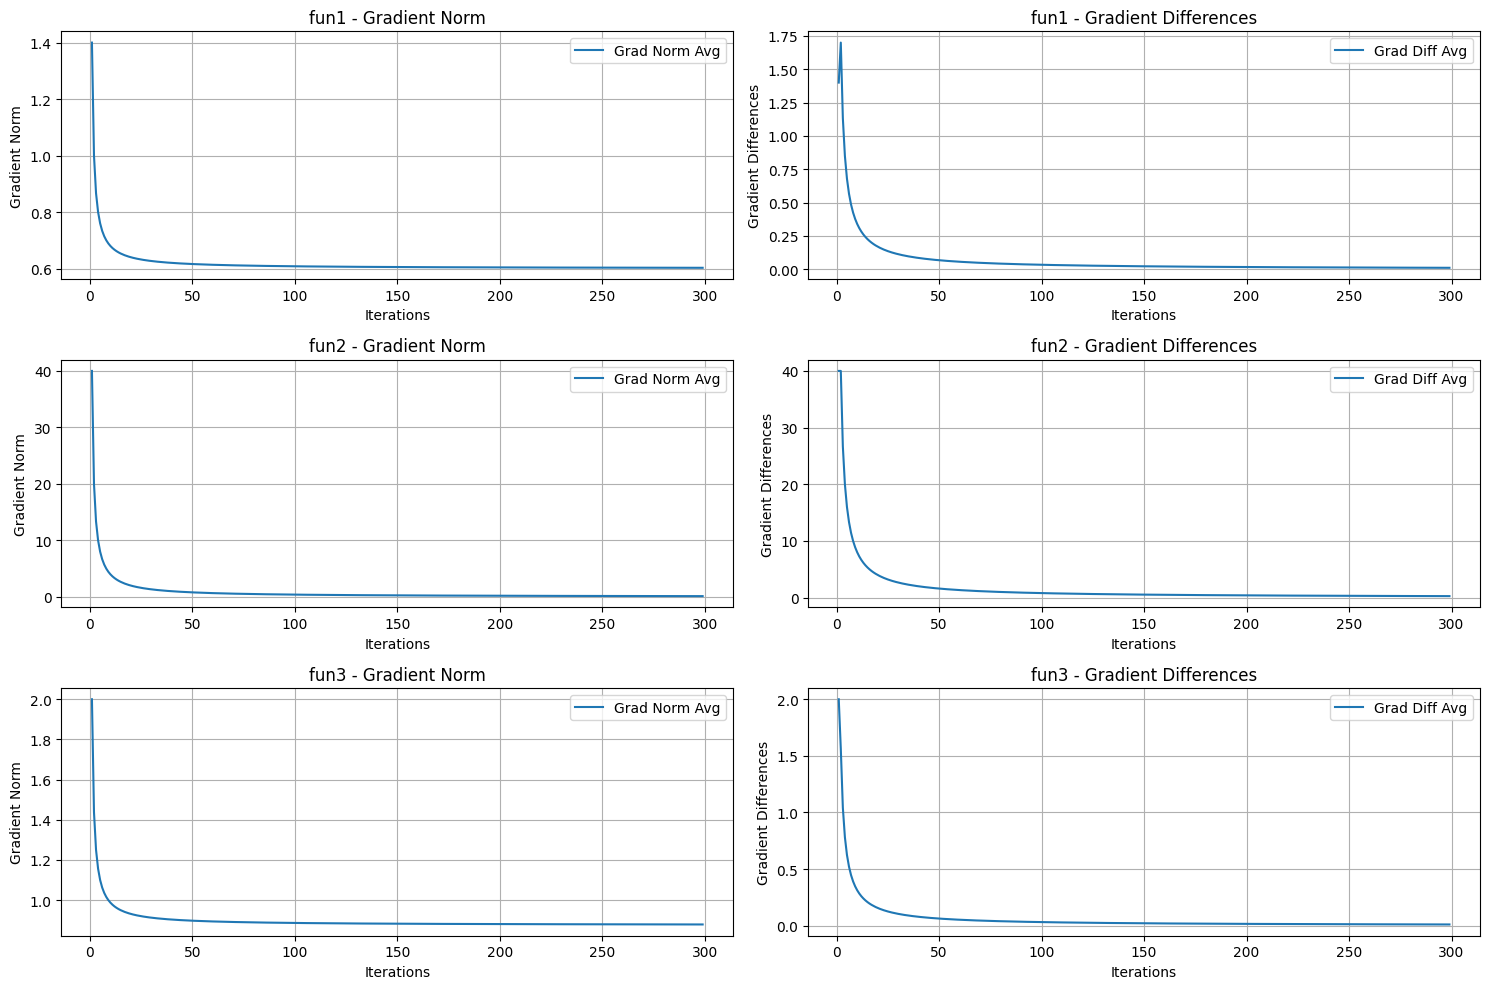

In [ ]:
# Plotting
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = [15.0, 10.0]

fig, axes = plt.subplots(3, 2, figsize=(15, 10))

for row, (fun, calc_grad, fun_name) in enumerate(functions):
    grad_norm_data = []
    grad_diff_data = []

    grad_norm, grad_diff = get_grads(fun, calc_grad, x0, nb_iters)
    grad_norm_data.append((np.arange(nb_iters - 1) + 1, grad_norm[1:]))
    grad_diff_data.append((np.arange(nb_iters - 1) + 1, grad_diff[1:]))

    # Plot gradient norm
    for x_data, grad_norm in grad_norm_data:
        running_avg_norm = np.cumsum(grad_norm) / np.arange(1, nb_iters)
        # axes[row, 0].scatter(x_data, grad_norm, alpha=0.5, label='Grad Norm')
        axes[row, 0].plot(x_data, running_avg_norm, label=f'Grad Norm Avg')
    axes[row, 0].set_title(f'{fun_name} - Gradient Norm')
    axes[row, 0].set_xlabel('Iterations')
    axes[row, 0].set_ylabel('Gradient Norm')
    axes[row, 0].legend()
    axes[row, 0].grid()

    # Plot gradient differences
    for x_data, grad_diff in grad_diff_data:
        running_avg_diff = np.cumsum(grad_diff) / np.arange(1, nb_iters)
        # axes[row, 1].scatter(x_data, grad_diff, alpha=0.5, label='Grad Diff')
        axes[row, 1].plot(x_data, running_avg_diff, label=f'Grad Diff Avg')
    axes[row, 1].set_title(f'{fun_name} - Gradient Differences')
    axes[row, 1].set_xlabel('Iterations')
    axes[row, 1].set_ylabel('Gradient Differences')
    axes[row, 1].legend()
    axes[row, 1].grid()

plt.tight_layout()
plt.show()

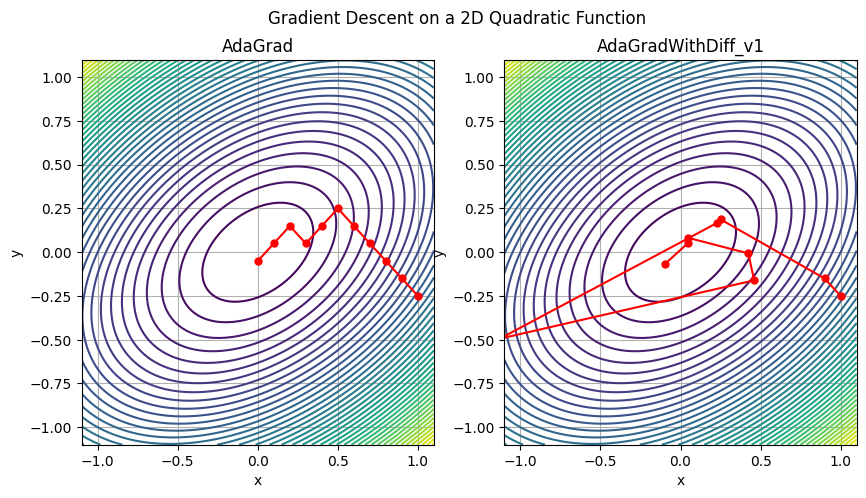

In [ ]:
f = lambda x, y: 2*x**2 + 3*y**2 - 2*x*y - 1

# Define the derivative of f(x, y)
def df(x, y):
    return np.array([4*x - 2*y, 6*y - 2*x])

# Gradient descent function
def gradient_descent(optimizer, iterations, x0, y0):
    xs, ys = [x0], [y0]
    x, y = x0, y0
    for _ in range(iterations):
        grad = df(x, y)
        x, y = optimizer.update(np.array([x, y]), grad)
        xs.append(x)
        ys.append(y)
    return xs, ys

# Parameters
LR_RATE = 0.1
EPS = 1e-8
BETA1 = 0.95
BETA2 = 0.999
ITERATIONS = 10
x0, y0 = 1.0, -0.25

# Create optimizers
optimizers = {
    'AdaGrad': AdaGrad(LR_RATE, EPS),
    'AdaGradWithDiff_v1': AdaGradWithDiff_v1(LR_RATE, EPS),
}

# Perform gradient descent using both optimizers
results = {}
for name, optimizer in optimizers.items():
    results[name] = gradient_descent(optimizer, ITERATIONS, x0, y0)

# Create the contour plot
x = np.linspace(-1.1, 1.1, 400)
y = np.linspace(-1.1, 1.1, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Gradient Descent on a 2D Quadratic Function')

for ax, (name, (xs, ys)) in zip(axes, results.items()):
    ax.contour(X, Y, Z, levels=50, cmap='viridis')
    ax.plot(xs, ys, 'ro-', markersize=5)

    # Annotate the points with iteration numbers
    # for i, (x, y) in enumerate(zip(xs, ys)):
    #     ax.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color='black')

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_title(name)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)

plt.show()


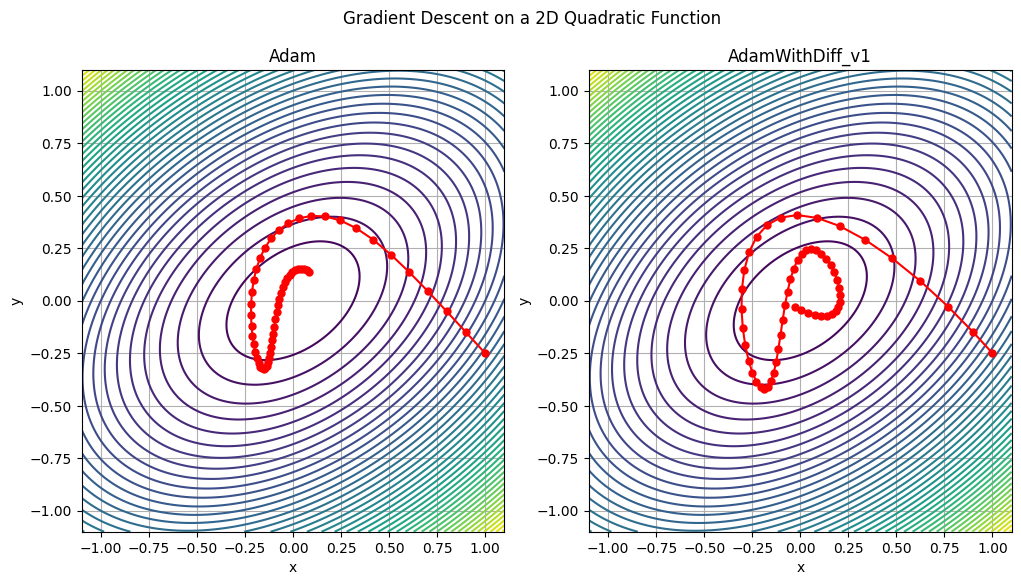

In [ ]:
f = lambda x, y: 2*x**2 + 3*y**2 - 2*x*y - 1

# Define the derivative of f(x, y)
def df(x, y):
    return np.array([4*x - 2*y, 6*y - 2*x])

# Gradient descent function
def gradient_descent(optimizer, iterations, x0, y0):
    xs, ys = [x0], [y0]
    x, y = x0, y0
    for _ in range(iterations):
        grad = df(x, y)
        x, y = optimizer.update(np.array([x, y]), grad)
        xs.append(x)
        ys.append(y)
    return xs, ys

# Parameters
LR_RATE = 0.1
EPS = 1e-8
BETA1 = 0.95
BETA2 = 0.999
ITERATIONS = 55
x0, y0 = 1.0, -0.25

# Create optimizers
optimizers = {
    'Adam': Adam(LR_RATE, BETA1, BETA2, EPS),
    'AdamWithDiff_v1': AdamWithDiff_v1(LR_RATE, BETA1, BETA2, EPS)
}

# Perform gradient descent using both optimizers
results = {}
for name, optimizer in optimizers.items():
    results[name] = gradient_descent(optimizer, ITERATIONS, x0, y0)

# Create the contour plot
x = np.linspace(-1.1, 1.1, 400)
y = np.linspace(-1.1, 1.1, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Gradient Descent on a 2D Quadratic Function')

for ax, (name, (xs, ys)) in zip(axes, results.items()):
    ax.contour(X, Y, Z, levels=50, cmap='viridis')
    ax.plot(xs, ys, 'ro-', markersize=5)

    # Annotate the points with iteration numbers
    # for i, (x, y) in enumerate(zip(xs, ys)):
    #     ax.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color='black')

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_title(name)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)

plt.show()
